# Exrcise 22: Galaxy vs quasar with deep learning

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).

---

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import corner
import h5py

from sklearn.base import  clone

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate

from astroML.utils import pickle_results

import pandas as pd
from IPython.display import display

%config InlineBackend.figure_format='retina'

## Prepare Data

In [5]:
file = '../solutions/galaxyquasar.csv'
data_csv = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5), dtype = str)
print(data_csv)

[['u' 'g' 'r' 'i' 'z' 'class']
 ['18.97213' '18.53676' '18.5828' '18.34936' '18.29215' 'QSO']
 ['19.24592' '17.47646' '16.47817' '16.04472' '15.68851' 'GALAXY']
 ...
 ['18.62718' '17.30876' '16.87371' '16.62399' '16.42296' 'GALAXY']
 ['19.5514' '18.27711' '17.62101' '17.21947' '17.03347' 'GALAXY']
 ['18.80772' '17.75751' '17.405' '17.2165' '17.12295' 'GALAXY']]


In [6]:
lab = np.char.replace(data_csv[1:,5], 'GALAXY', '0')
lab = np.char.replace(lab, 'QSO', '1').astype(int)

ug = data_csv[1:,0].astype(float) - data_csv[1:,1].astype(float)
gr = data_csv[1:,1].astype(float) - data_csv[1:,2].astype(float)
ri = data_csv[1:,2].astype(float) - data_csv[1:,3].astype(float)
iz = data_csv[1:,3].astype(float) - data_csv[1:,4].astype(float)

data = np.column_stack((ug,gr,ri,iz))

galaxies = data[: , :4][lab==1].astype(float)
quasars = data[: , :4][lab==0].astype(float)

names = ['u-g', 'g-r', 'r-i', 'i-z']

First we check the distribution of the features

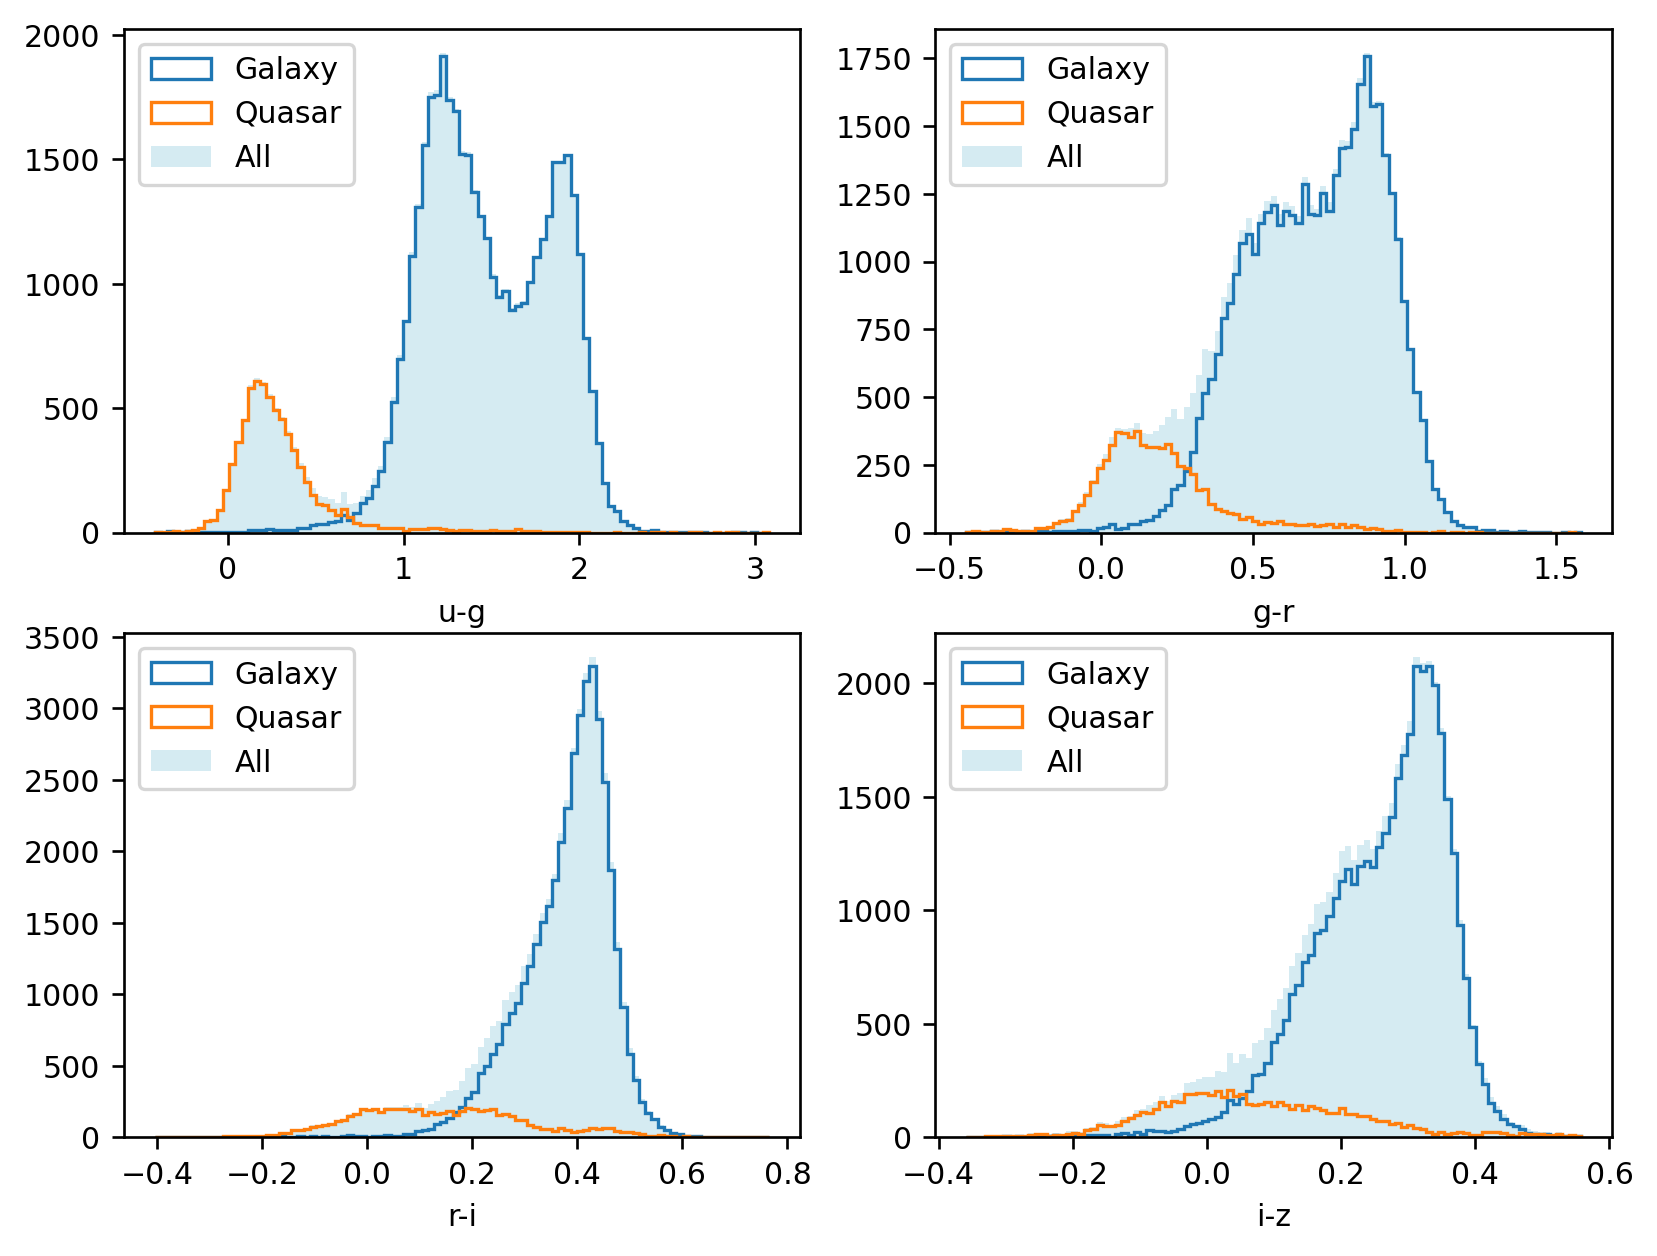

In [7]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

# bins = 'auto'
quant_list = [(0.0005, 0.9995),(0.001, 0.9995),(0.001, 0.999),(0.003, 0.997)] # Got boundaries by eye
bounds = []

for ax,color, name, quant in zip(axs.flatten() ,data[:,:4].T,names, quant_list):
    
    min, max = np.quantile(color, quant)
    bounds.append([min,max])
    bins = np.linspace(min, max, 100)   
    gala = color[lab==0]
    quas = color[lab==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    
plt.tight_layout;

From color distributions it seems that u-g is by far the most informative feature as it shows a clear bimodality differentiating galaxies and quasars. For the other colors, quasars only create a small bump in the total distribution.

In the above histograms we choose x axes boundaries using data quantiles to exclude outliers and look at bulk distributions for each color. 

Checking histograms including all data we see that there are some outliers: we trim them from the data sample.


In [8]:
# Remove outliers
bounds = np.array(bounds)
data_t = data.T

# mask on transposed data matrix
mask1 = np.array([np.logical_and(bounds[i,0] < data.T[i], data.T[i] < bounds[i,1]) for i in [0,1,2,3]])
mask2 = np.all(mask1,axis=0)

data_clean = data[mask2,:]
lab_clean = lab[mask2]

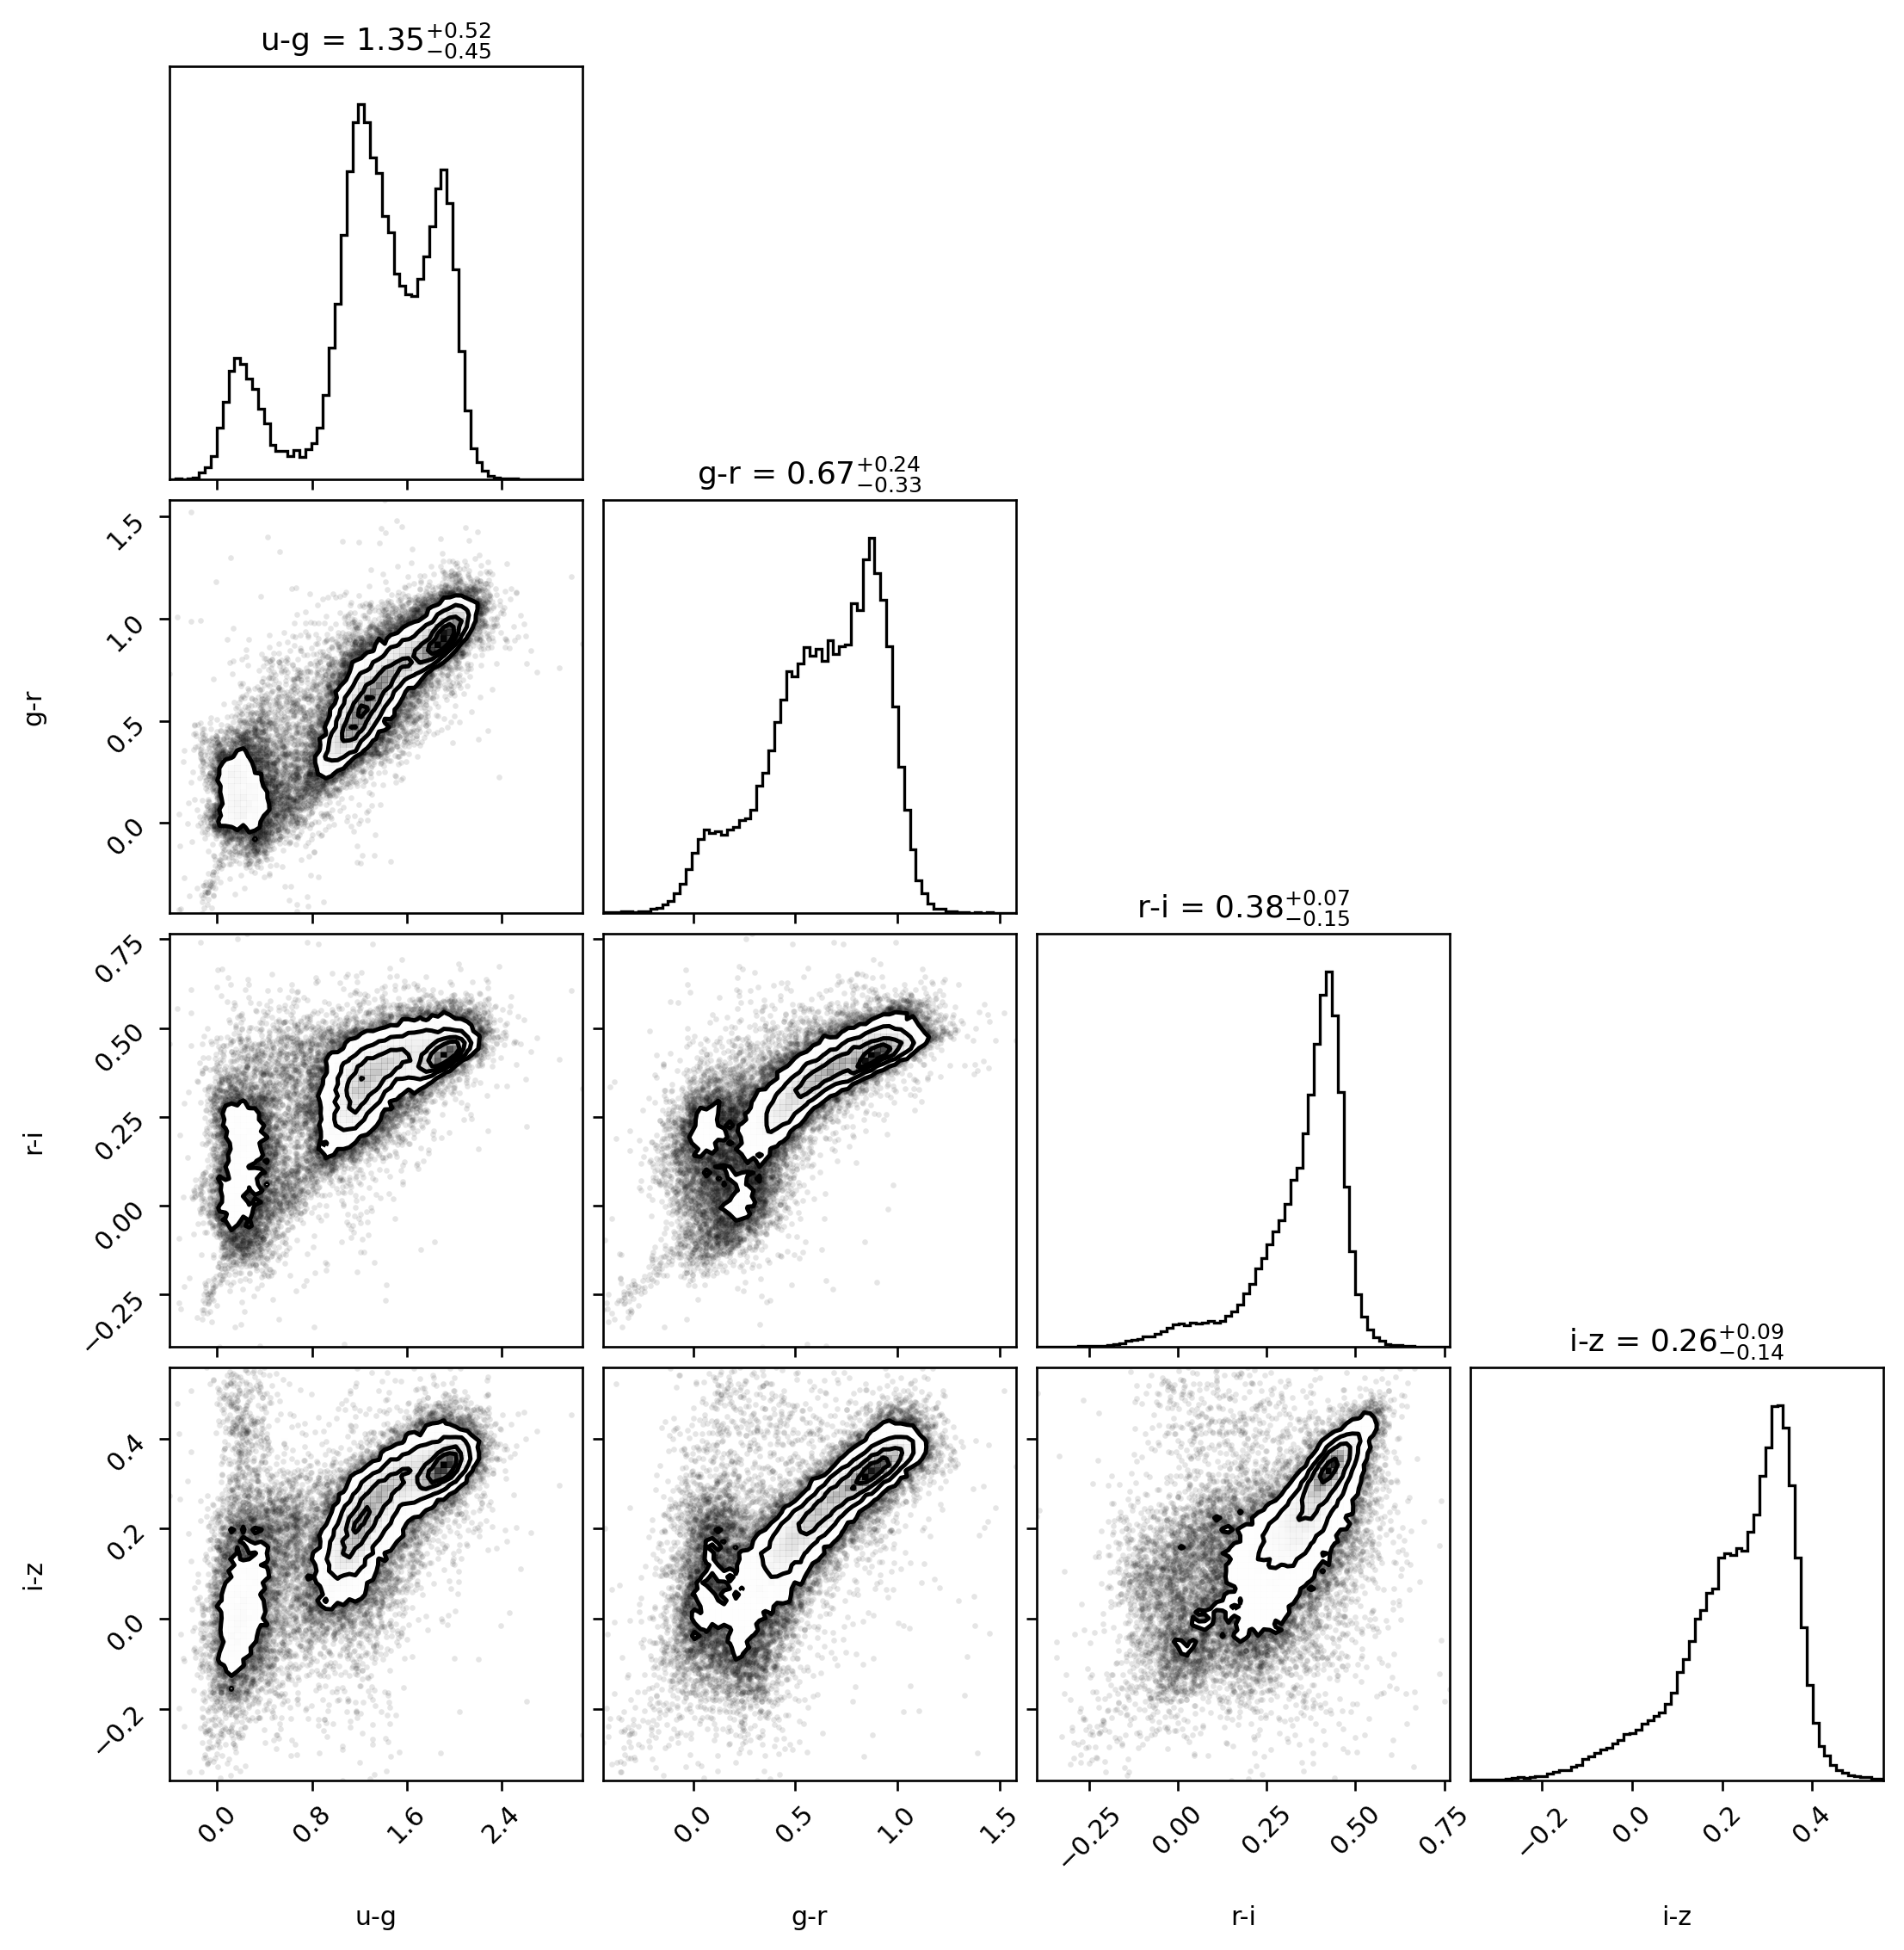

In [9]:
corner.corner(data_clean, labels = names, bins=70, show_titles=True);

In [10]:
# Train and test sets
X = data_clean
y = lab_clean

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=0)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_tot_scaled = scaler.transform(X)

# Classification with Neural Networks

The functions below are used to train different classifiers and then compare them.

We want to explore hyperparameters computing k-fold cross-validated metrics on the train set, and find the best classfier for the test set.


In [11]:
# USEFUL FUNCTIONS
###################################################

def run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
        
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    
    Kwargs: 
    
    proba = True, can be set to False if the classifier doeas not have predict_proba() method (like SVC).
    name = 'custom_name' , to use custom name.
    test_set = False , can be set to True to compute metrics on the test set.
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    # Setting default kwargs
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    test_metrics = kwargs.get('test_metrics', False)
    kfolds = kwargs.get('kfolds', 5)
    
    print(f'Fitting {name}')

    clf.fit(X_train, y_train) # Fit classifier
    
    if proba == False:
        y_probs = clf.decision_function(X_test)
    else:
        y_probs = clf.predict_proba(X_test)[:, 1]
        
    y_pred = clf.predict(X_test)
    
    #-------------------------------------------------------------------------------
    if test_metrics == True:
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        sigmas = np.array([.0,.0, .0])
    else:
        score_list = ['accuracy', 'recall', 'precision' ]
        cv_results = cross_validate(clf, X_train, y_train, scoring = score_list, 
                                    n_jobs=-1, verbose=1, cv=kfolds )

        accur = np.mean(cv_results['test_accuracy'])
        accur_sigma = np.std(cv_results['test_accuracy'])
        complet = np.mean(cv_results['test_recall'])
        complet_sigma = np.std(cv_results['test_recall'])
        contam = np.mean(1 - cv_results['test_precision'])
        contam_sigma = np.std(1 - cv_results['test_precision'])
        
        sigmas = np.array([accur_sigma, complet_sigma, contam_sigma])
        
    #-------------------------------------------------------------------------------    
    
    metrics = np.array([accur, complet, contam])
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves, sigmas]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list (classifiers_list, **kwargs):
    '''
    DO NOT USE WITH SVC etc (without .predict_proba() method): use run_classifier() on the single clf and then append info manually
    
    Trains and evalutate performance of a list of classifiers
   
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function
    
    kwargs:
    names = ['name1','name2',..] , to use custom name list for classifiers
    test_metrics =False , can be set to True to compute metrics on the test set
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    test_metrics = kwargs.get('test_metrics',False)
    kfolds = kwargs.get('kfolds', 5)
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier(clf, name=name, test_metrics=test_metrics, kfolds=kfolds ))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True, figtitle='none'):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    
    kwargs:
    figtitle = 'chosen title' , to set a chosen title for the two figures
    '''
    
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    sigmas_arr = np.array([results[2] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9, 4.5), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        # fig = plt.figure()
        fig, axs = plt.subplots(1,2)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        ax1 = axs[0]
        ax2 = axs[1]
        
        # fig.subplots_adjust(hspace=0.5, wspace=0.5)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0.9, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.9, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(10,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        margins = [0.0005,0.005,0.0005]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics, sigmas in zip(names, metrics_arr.T, sigmas_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)
                ax.errorbar(x+width*j, metrics[i], yerr=sigmas[i],  fmt='.k', ecolor='gray', lw=1, capsize = 2, markersize=5)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]-sigmas_arr[i]) - margins[i], np.max(metrics_arr[i]  + sigmas_arr[i]) + margins[i]) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

First we compare base MLP and the best calssifier from W19 (K-nearest neighbors) using metrics on the TEST SET

In [236]:
# Define classifiers

mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

kneighbors = KNeighborsClassifier(9)


In [242]:
classifiers_list1 = [mlp_base, kneighbors]

# info_list1 = run_classifier_list(classifiers_list1, test_metrics=False, kfolds=5) 
info_list1 = run_classifier_list(classifiers_list1, test_metrics=True) 


Fitting MLPClassifier(hidden_layer_sizes=(5,))
Fitting KNeighborsClassifier(n_neighbors=9)


name  accuracy  completeness  \
1     KNeighborsClassifier(n_neighbors=9)  0.987307      0.943306   
0  MLPClassifier(hidden_layer_sizes=(5,))  0.986635      0.934731   

   contamination  
1       0.034146  
0       0.030632

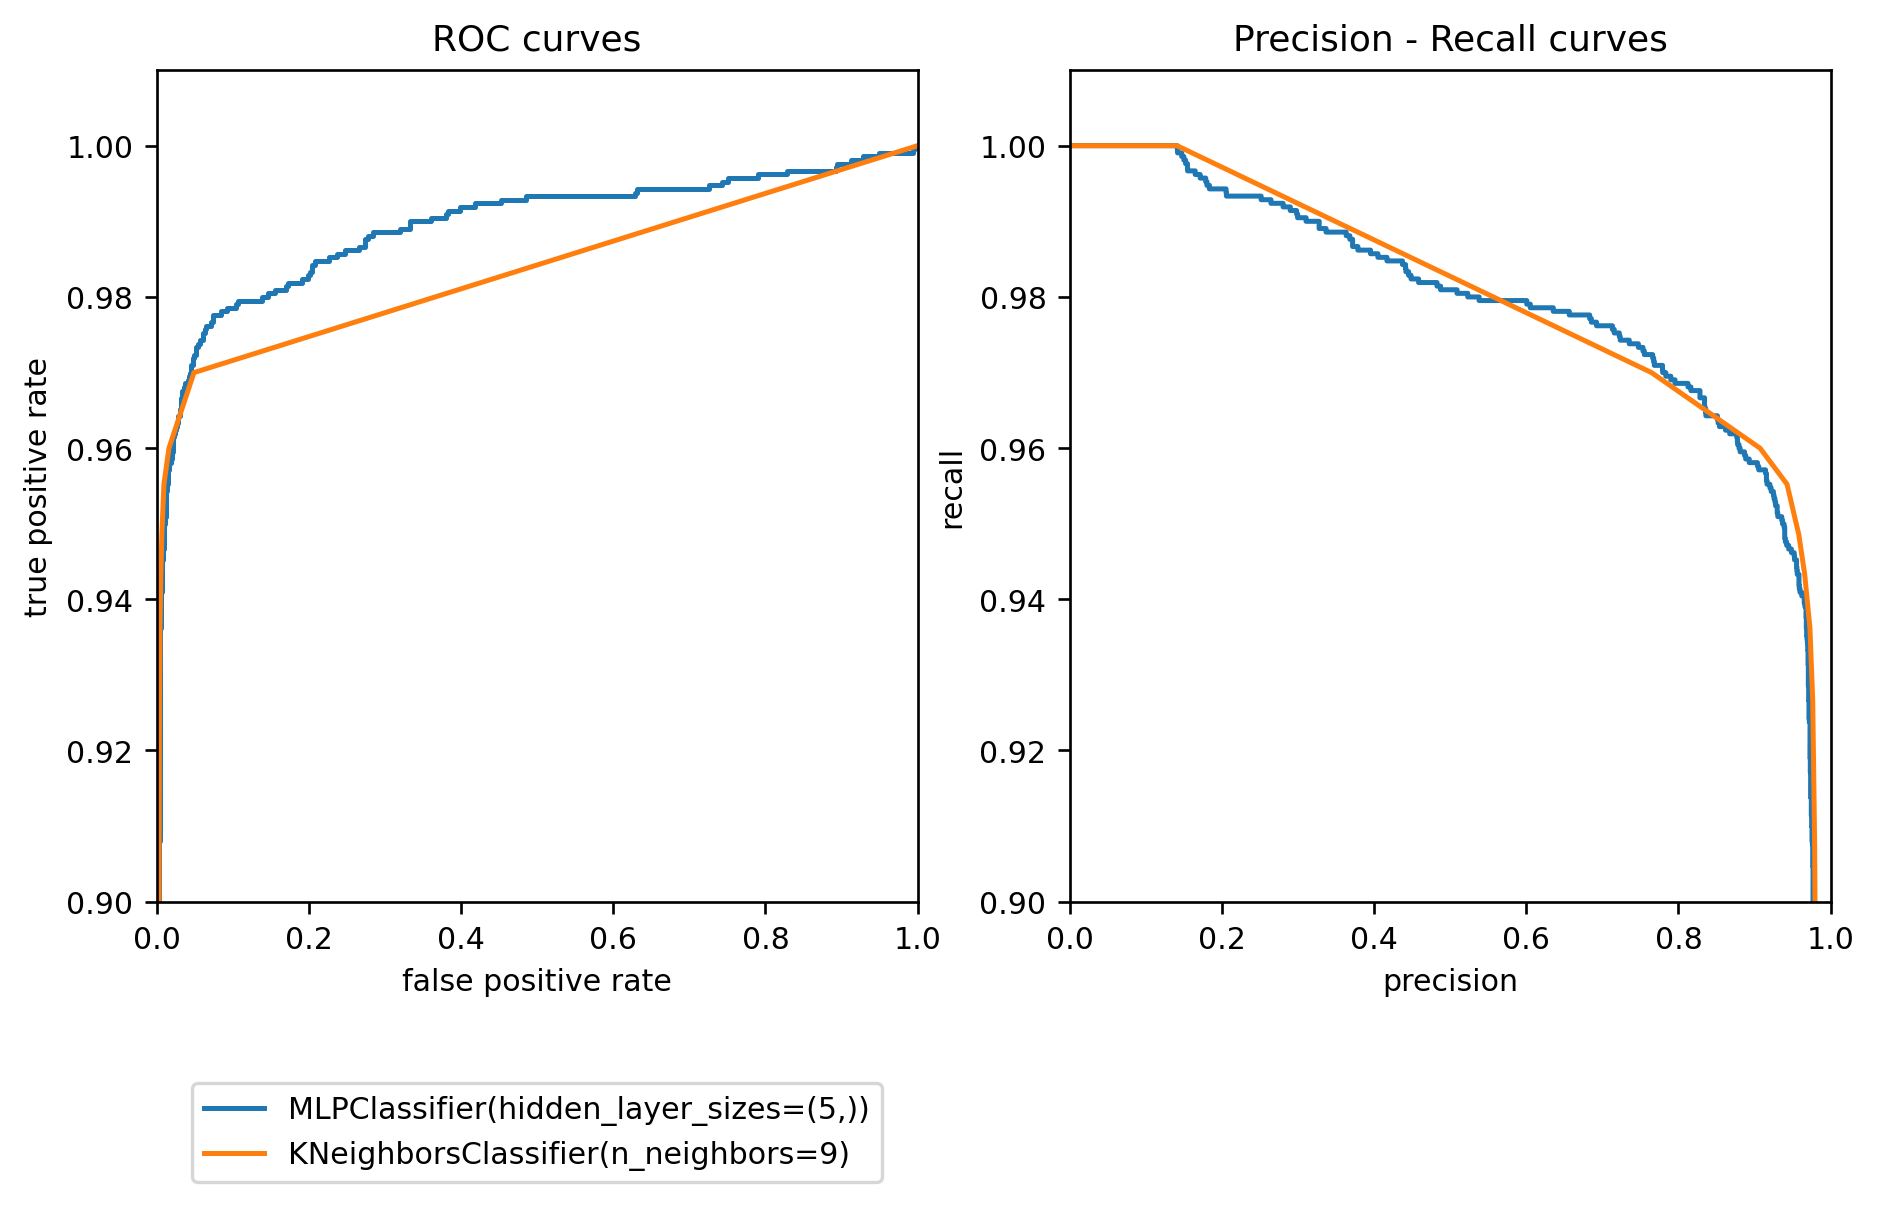

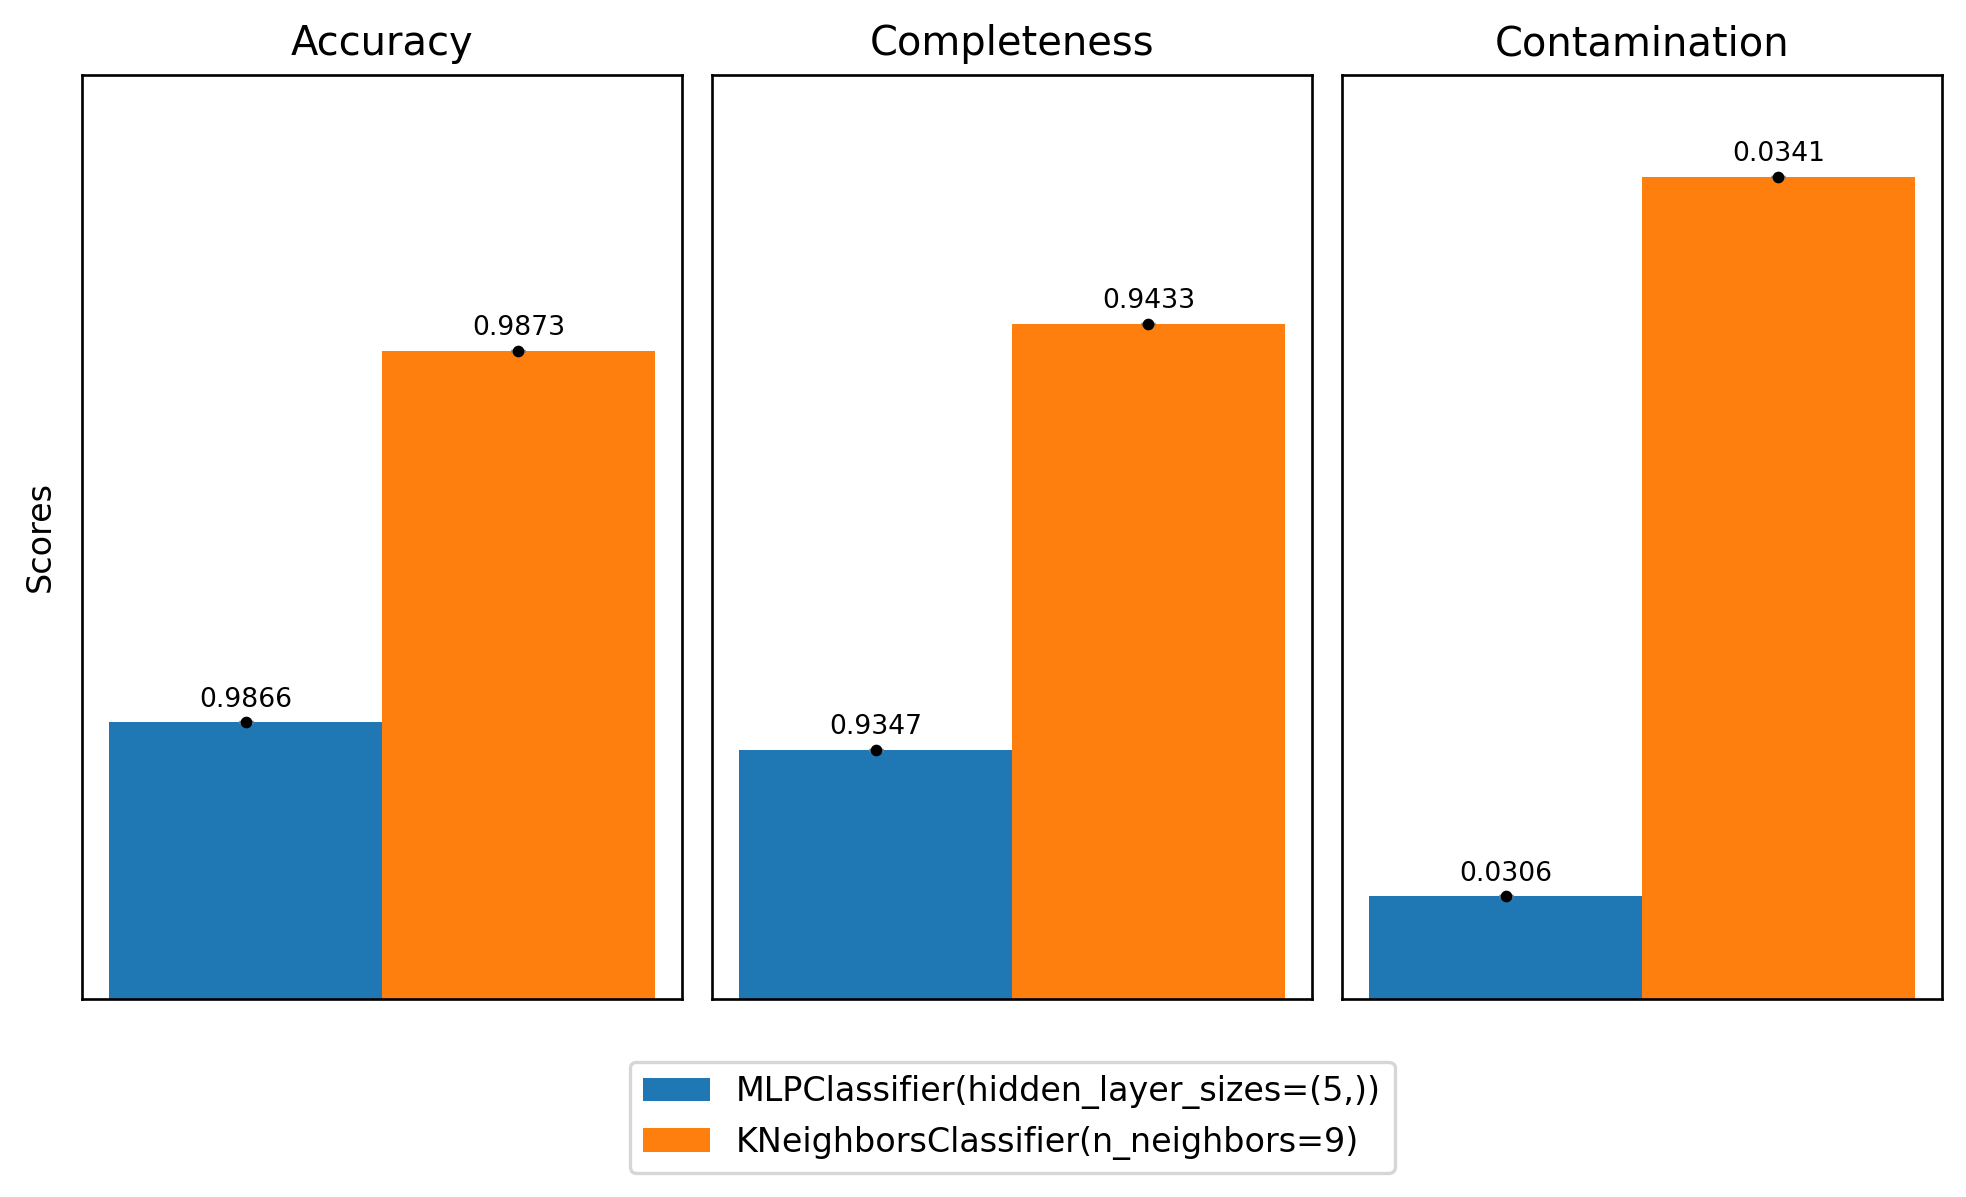

In [251]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

# a1 = compare_classifiers(info_list1, figtitle='Base MLP vs KNN' )
a1 = compare_classifiers(info_list1 )


Base versions of MLP CLassifier have performances similar to the best classifiers of the previous notebooks (K-neighbors). 


---
## Ranking of classifiers heavily depends on test set choice
We want to see if accuracy, recall and contamination could be robust performance metrics for different classifiers. We compute the metrics using different random test set choices (always 0.3 of the total), and plot histograms of the results.

In [60]:
# CV for metrics using base MLP CLassifier
score_list = ['accuracy', 'recall', 'precision' ]
k=100
splitter = ShuffleSplit(n_splits = k, test_size=0.3)
cv_results = cross_validate(mlp_base, X_tot_scaled, y, scoring = score_list, n_jobs=-1, verbose=1, cv=splitter )


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


In [61]:
acc = cv_results['test_accuracy']
recall = cv_results['test_recall']
cont = 1 - cv_results['test_precision']
labels = ['accuracy', 'recall', 'contamination' ]
print('Base MLP Classifier:')
for metric, name in zip([acc,recall,cont], labels):
    mean = np.mean(metric)
    sigma = np.std(metric)
    print(f'{name}:  mean = {mean:.4f}, mean_err = {sigma/np.sqrt(k):.4f}, sigma = {sigma:.4f}')

Base MLP Classifier:
accuracy:  mean = 0.9863, mean_err = 0.0001, sigma = 0.0009
recall:  mean = 0.9355, mean_err = 0.0005, sigma = 0.0054
contamination:  mean = 0.0337, mean_err = 0.0004, sigma = 0.0038


In [63]:
# CV for metrics using K-neighbor
score_list = ['accuracy', 'recall', 'precision' ]
k=100
splitter = ShuffleSplit(n_splits = k, test_size=0.3)
cv_results_KN = cross_validate(kneighbors, X_tot_scaled, y, scoring = score_list, n_jobs=-1, verbose=1, cv=splitter )


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished


In [64]:
acc = cv_results_KN['test_accuracy']
recall = cv_results_KN['test_recall']
cont = 1 - cv_results_KN['test_precision']
labels = ['accuracy', 'recall', 'contamination' ]

print('K-neighbors Classifier:')
for metric, name in zip([acc,recall,cont], labels):
    mean = np.mean(metric)
    sigma = np.std(metric)
    print(f'{name}:  mean = {mean:.4f}, mean_err = {sigma/np.sqrt(k):.4f}, sigma = {sigma:.4f}')

K-neighbors Classifier:
accuracy:  mean = 0.9870, mean_err = 0.0001, sigma = 0.0008
recall:  mean = 0.9453, mean_err = 0.0004, sigma = 0.0042
contamination:  mean = 0.0387, mean_err = 0.0004, sigma = 0.0038


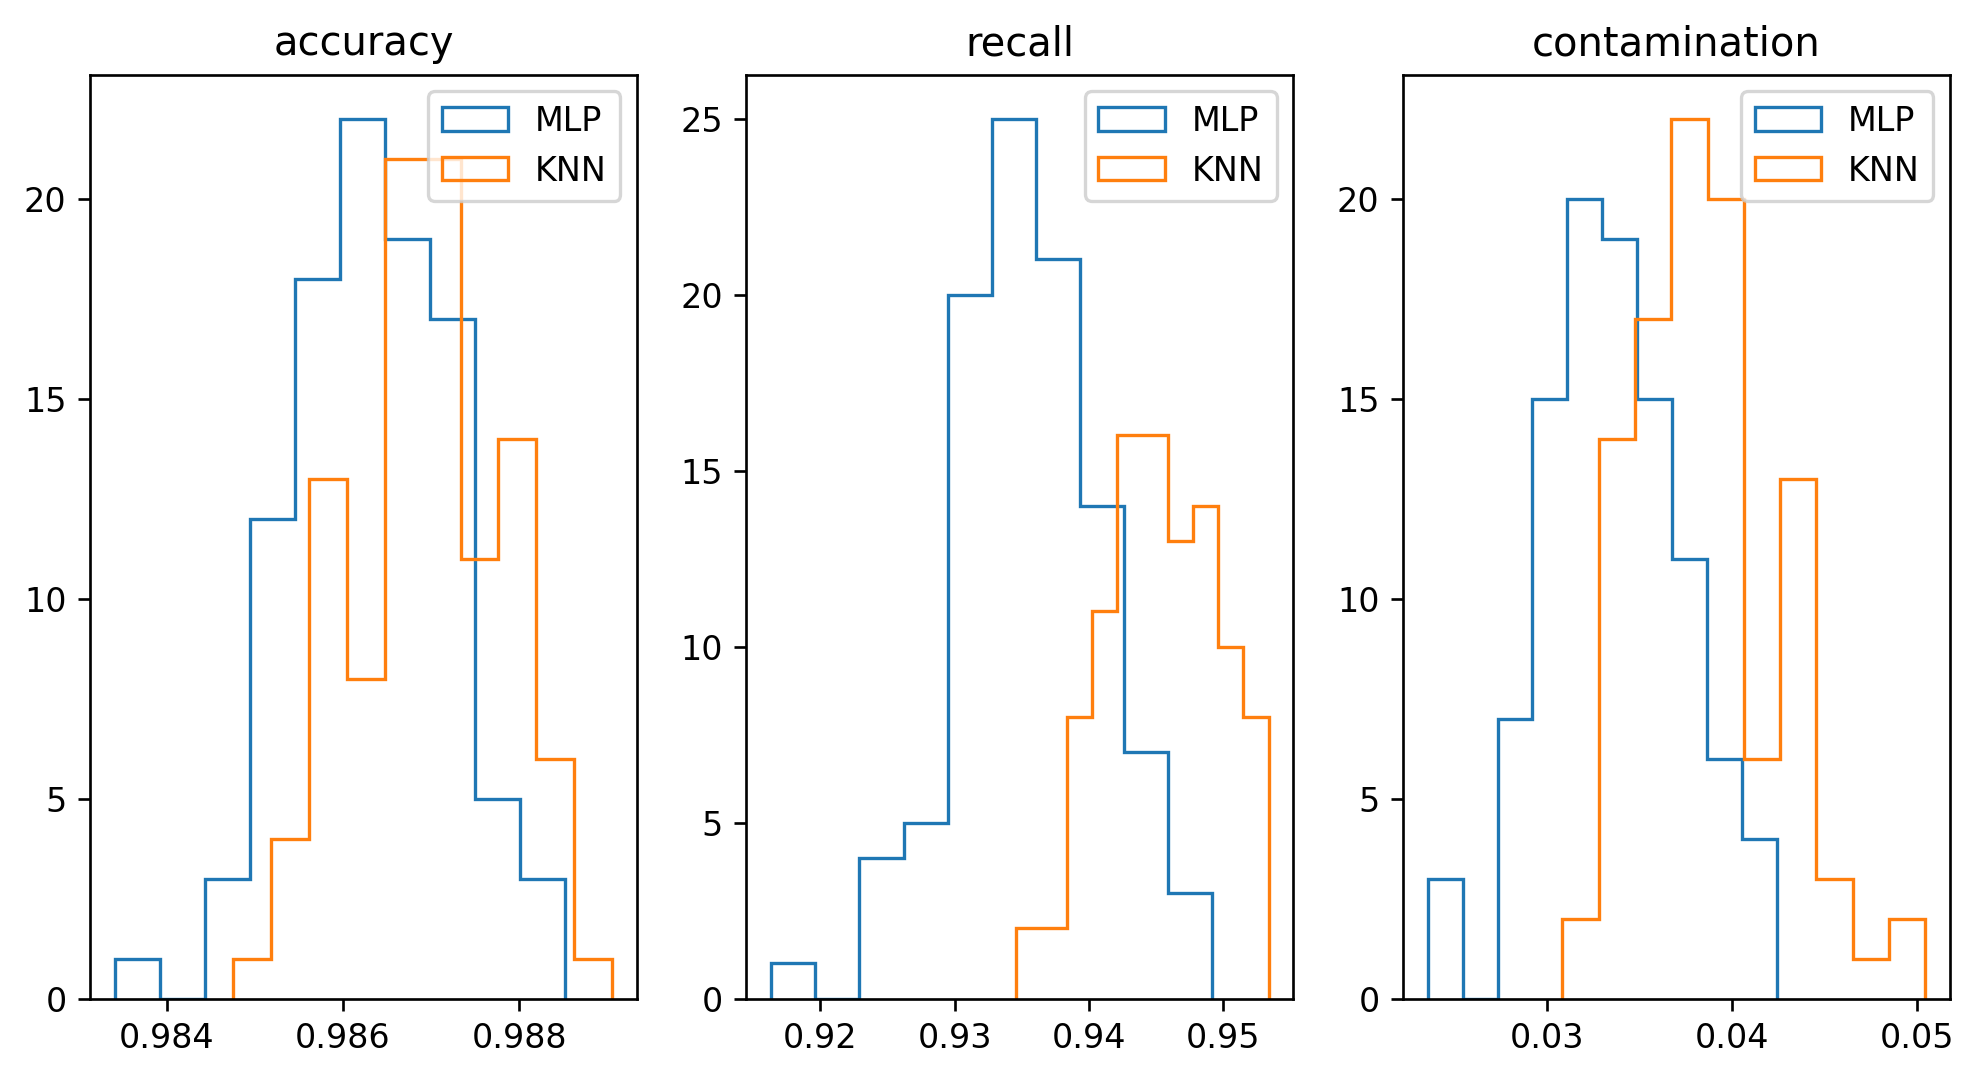

In [67]:
fig, axs = plt.subplots(1,3)

for res, name in zip([cv_results, cv_results_KN], ['MLP', 'KNN']):
    acc = res['test_accuracy']
    recall = res['test_recall']
    cont = 1 - res['test_precision']
    
    for ax, metric, title in zip(axs, [acc,recall,cont], labels):
        ax.hist(metric, histtype='step', label = name)
        ax.set_title(title)
        ax.legend()

We see that distributions overlap, so when we compute metrics to rank classifier performance on our test set, we should be aware that those are not truly representative for a "general" test set. We can repeat this procedure after having tuned hyperparameters to check how much is the improvement.

## Tuning Hyperparameters


#### Number of neurons - single layer


In [192]:
mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

list = []
for n_neurons in [4,10,30,100,150,]:
    mlp_base_mod = clone(mlp_base)
    mlp_base_mod.set_params(hidden_layer_sizes=(n_neurons))
    list.append(mlp_base_mod)
    
clf_list_nn = [mlp_base, *list]

In [ ]:
kfolds = 20
info_list_nn = run_classifier_list(clf_list_nn, kfolds=kfolds)

name  accuracy  completeness  \
4   MLPClassifier(hidden_layer_sizes=100)  0.987191      0.944082   
5   MLPClassifier(hidden_layer_sizes=150)  0.986990      0.944082   
3    MLPClassifier(hidden_layer_sizes=30)  0.986846      0.942242   
2    MLPClassifier(hidden_layer_sizes=10)  0.986443      0.938553   
0  MLPClassifier(hidden_layer_sizes=(5,))  0.986385      0.936096   
1     MLPClassifier(hidden_layer_sizes=4)  0.986241      0.936505   

   contamination  
4       0.035854  
5       0.037207  
3       0.036442  
2       0.035859  
0       0.033884  
1       0.035245

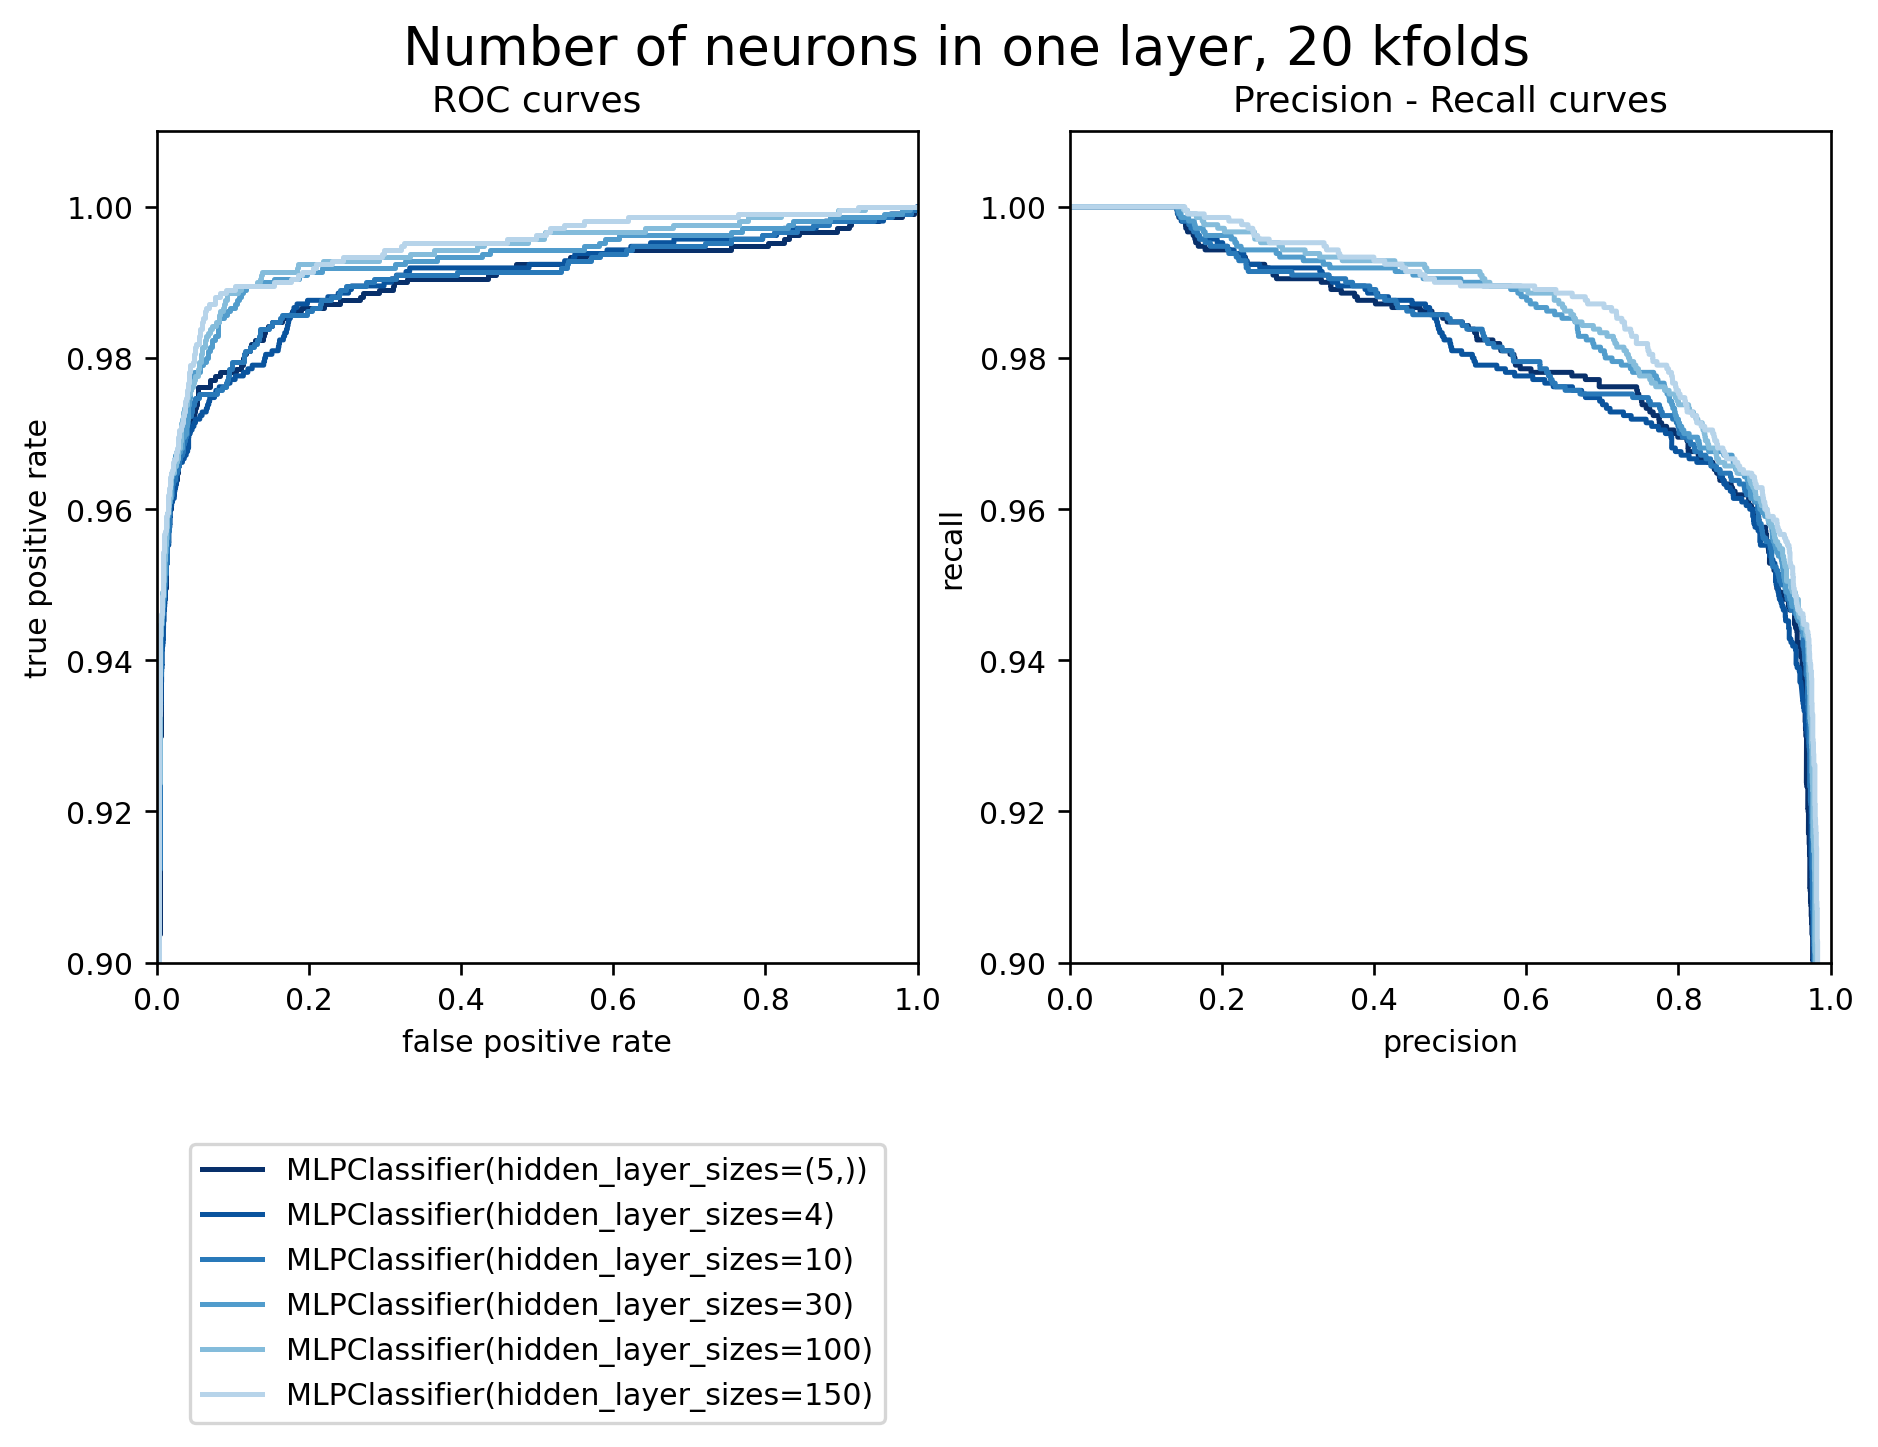

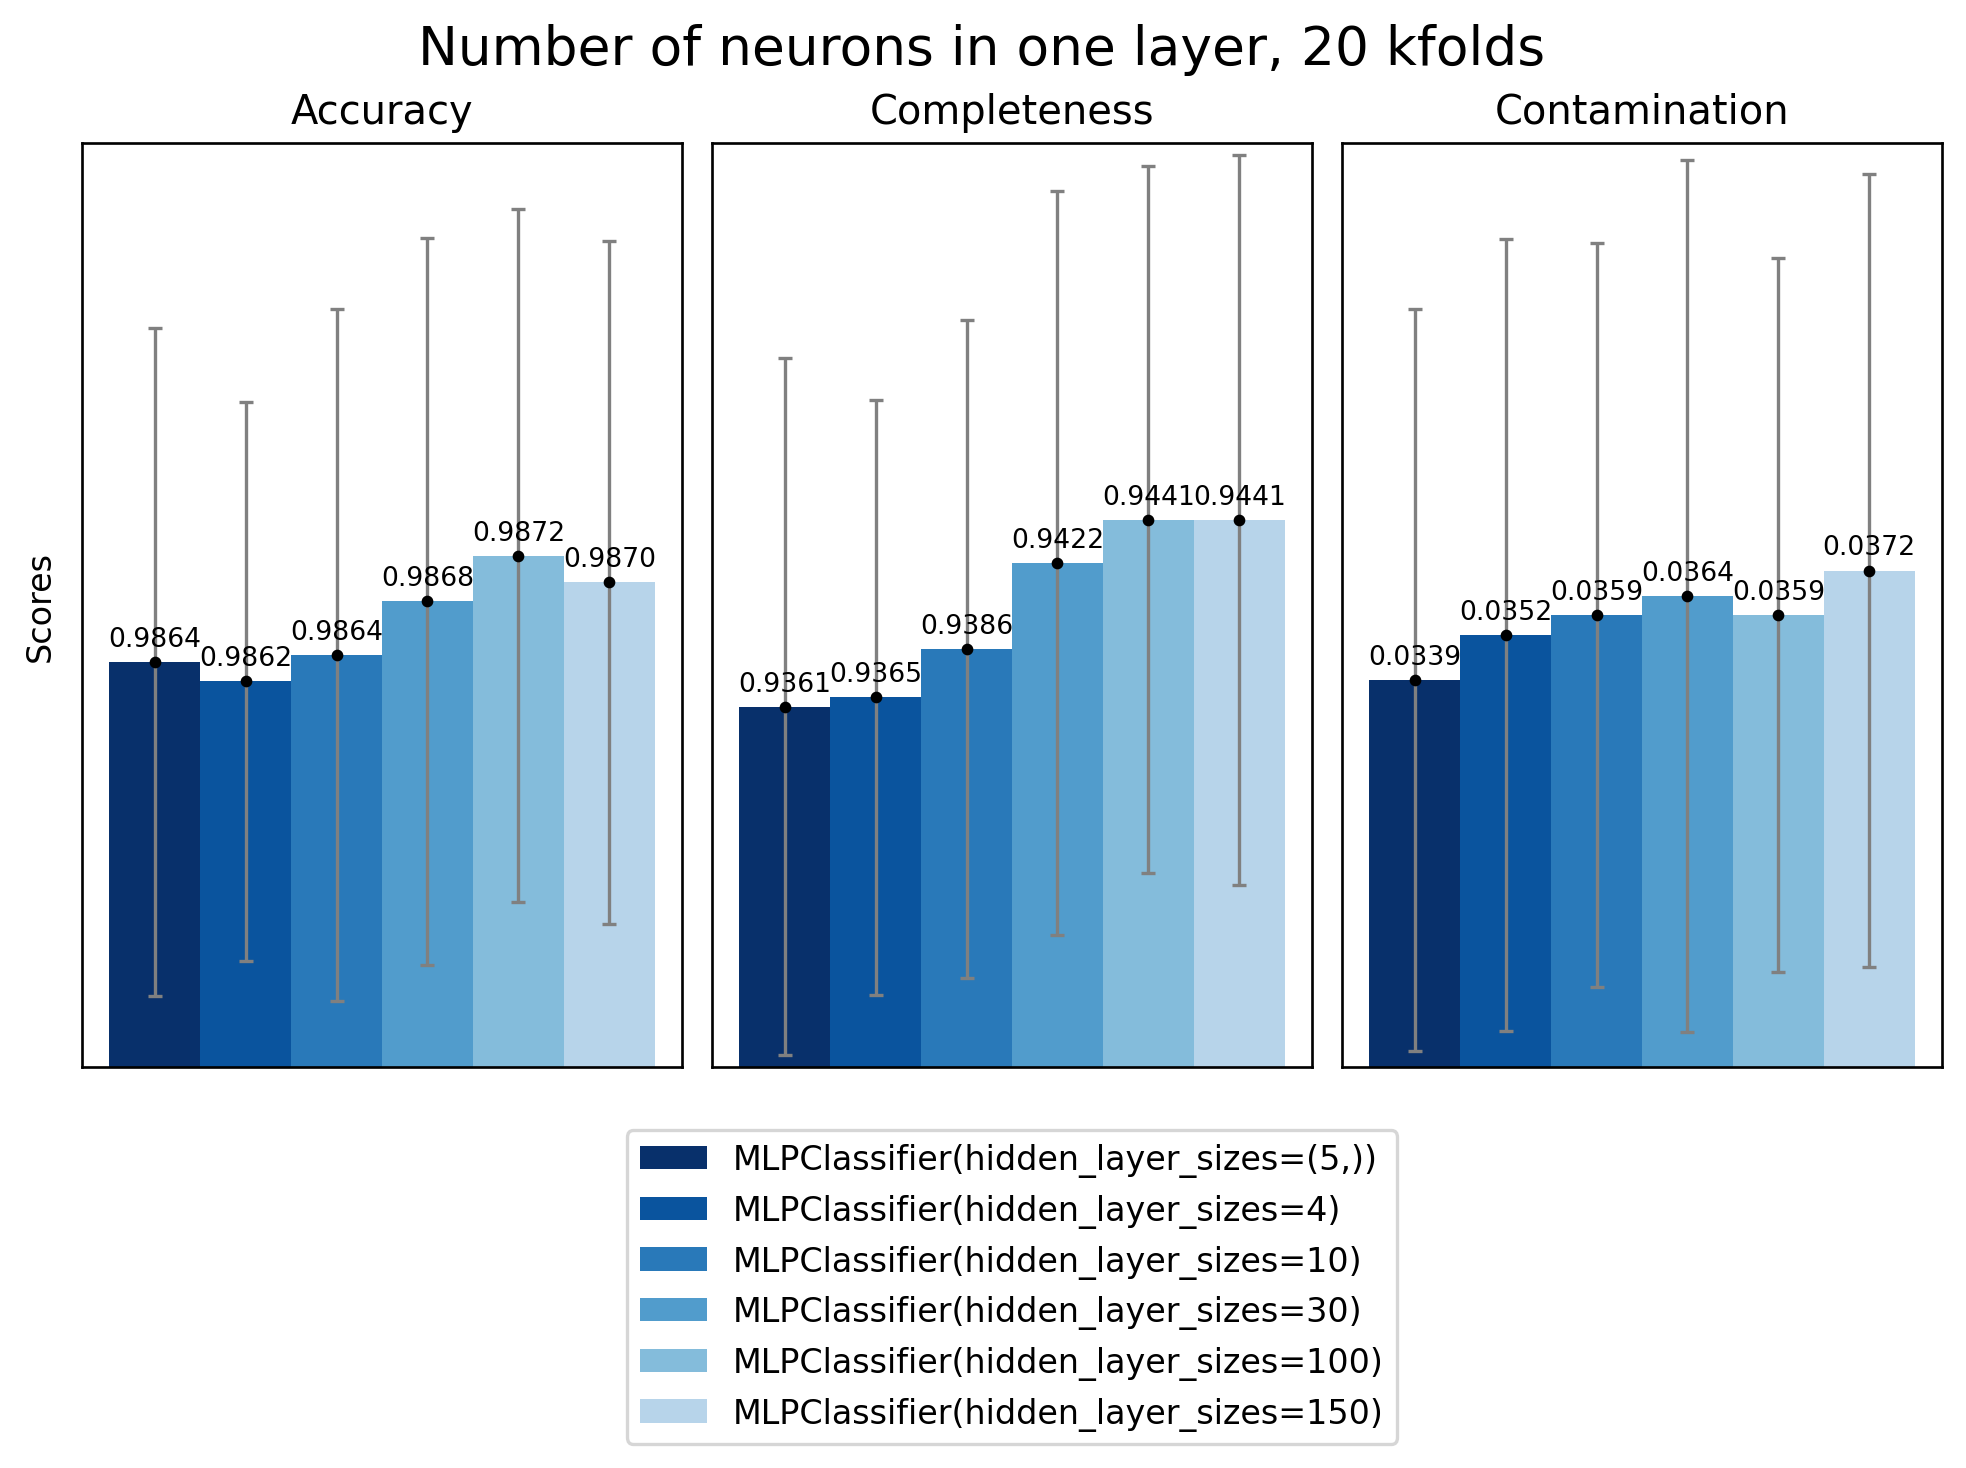

In [198]:

# ---------------Change colormap ----------------------------------------
cmap=plt.cm.Blues_r
c = cycler('color', cmap(np.linspace(0,0.7,len(info_list_nn))) )
plt.rcParams["axes.prop_cycle"] = c

# cmap=plt.cm.tab10
# c = cycler('color', cmap(range(10)))
# plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------

a_nn = compare_classifiers(info_list_nn, figtitle='Number of neurons in one layer, 20 kfolds')


It seems that increasing the number of neurons is beneficial to a single-layer MLP

#### Number of layers


In [164]:
mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

list = []
for n_l in np.arange(2,6,1):
    layers = tuple(np.full(n_l,5)) 
    mlp_base_mod = clone(mlp_base)
    mlp_base_mod.set_params(hidden_layer_sizes=layers)
    list.append(mlp_base_mod)
    
clf_list_nl = [mlp_base, *list]

In [ ]:
kfolds = 20
info_list_nl = run_classifier_list(clf_list_nl, kfolds=kfolds)

name  accuracy  completeness  \
1           MLPClassifier(hidden_layer_sizes=(5, 5))  0.986846      0.941828   
4  MLPClassifier(hidden_layer_sizes=(5, 5, 5, 5, 5))  0.986788      0.941626   
2        MLPClassifier(hidden_layer_sizes=(5, 5, 5))  0.986702      0.943060   
3     MLPClassifier(hidden_layer_sizes=(5, 5, 5, 5))  0.986529      0.943058   
0             MLPClassifier(hidden_layer_sizes=(5,))  0.986385      0.937529   

   contamination  
1       0.036054  
4       0.036239  
2       0.038277  
3       0.039422  
0       0.035310

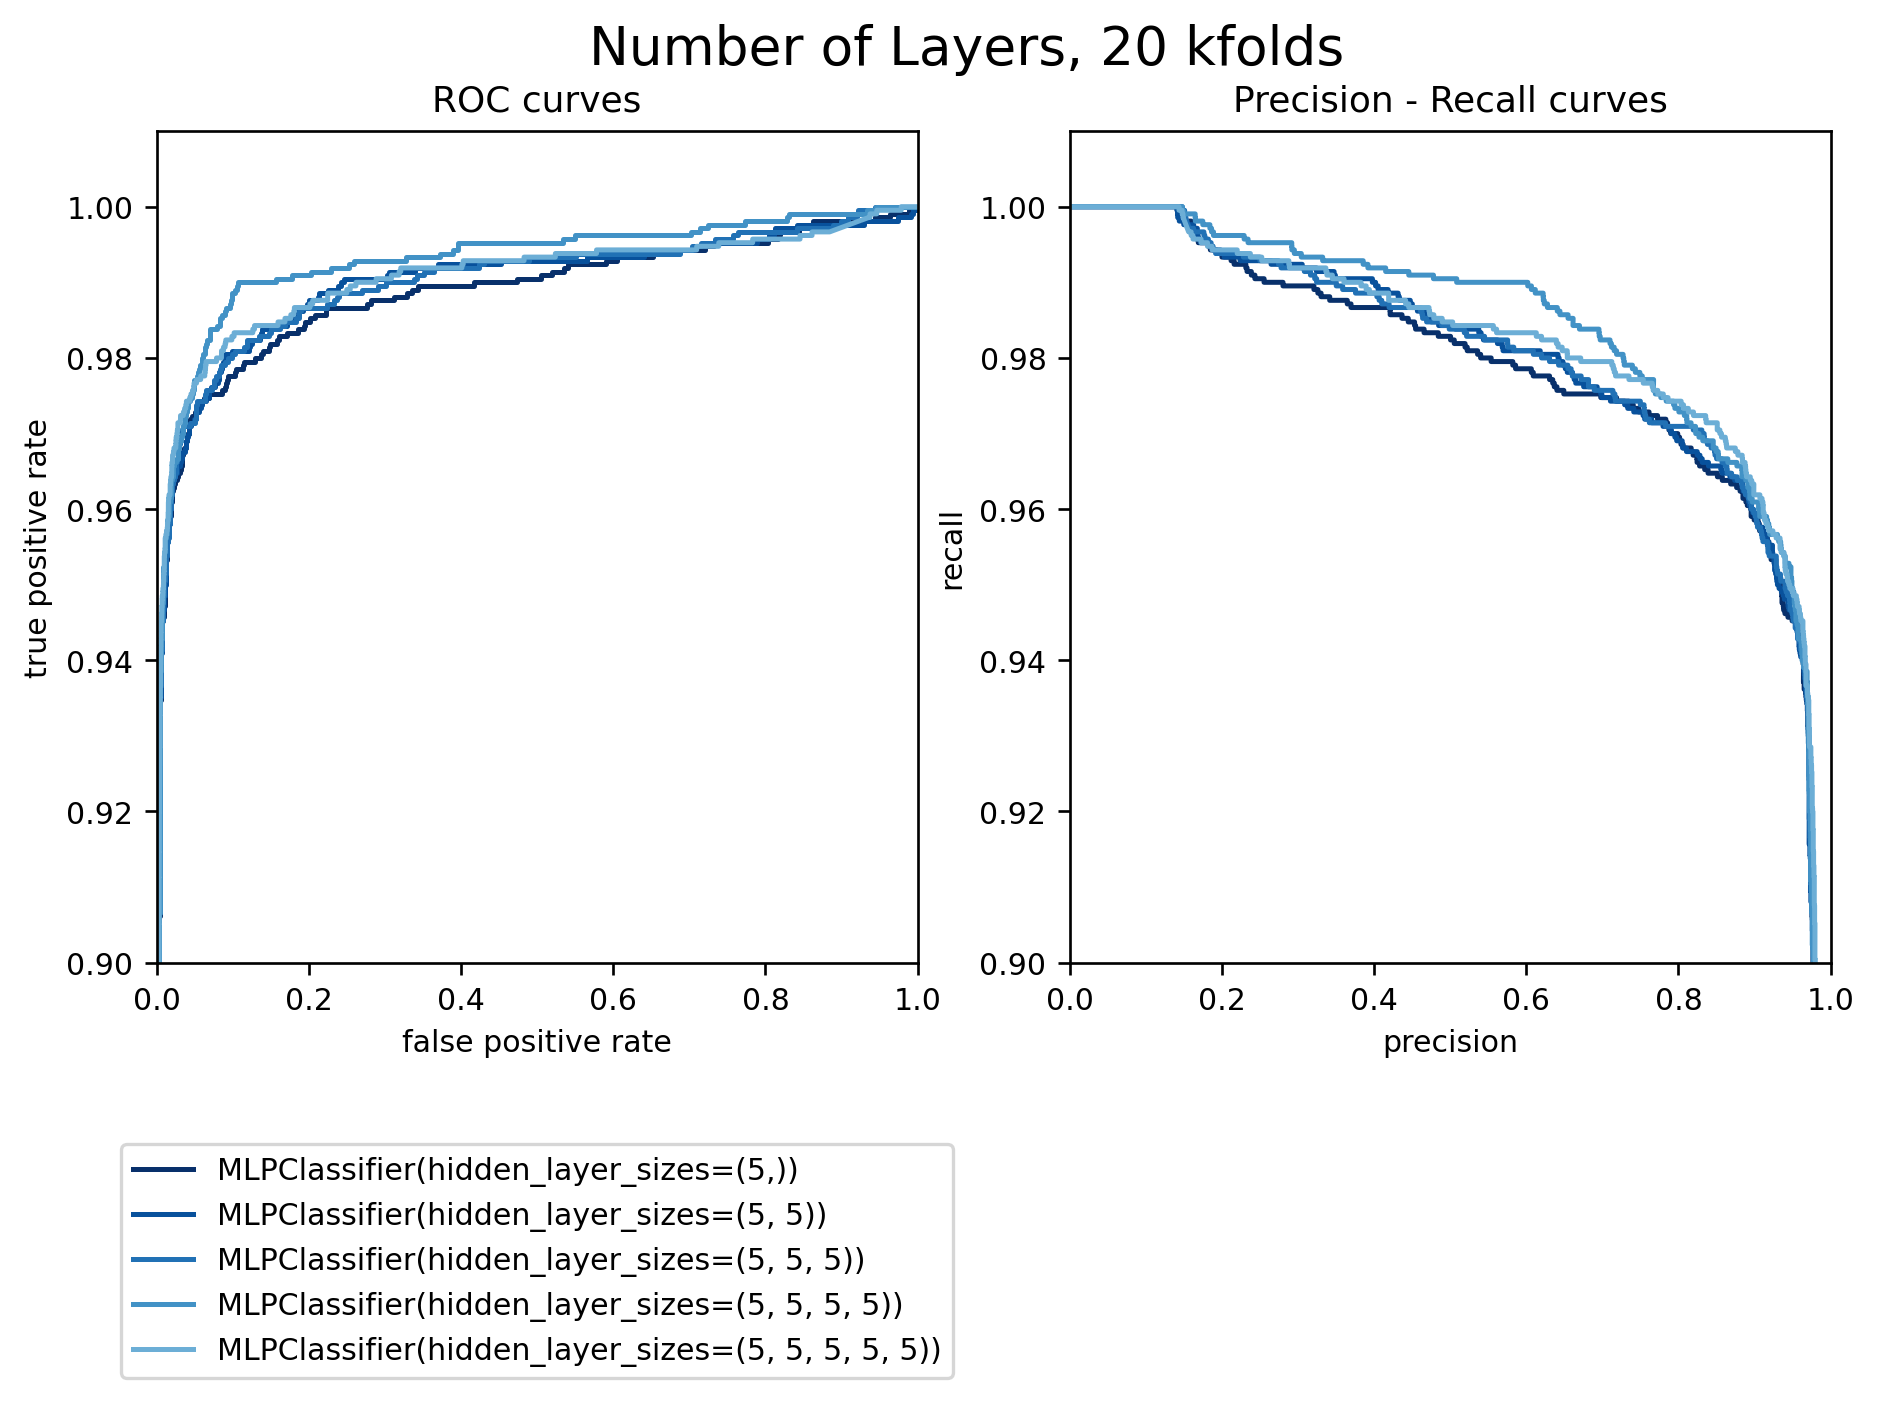

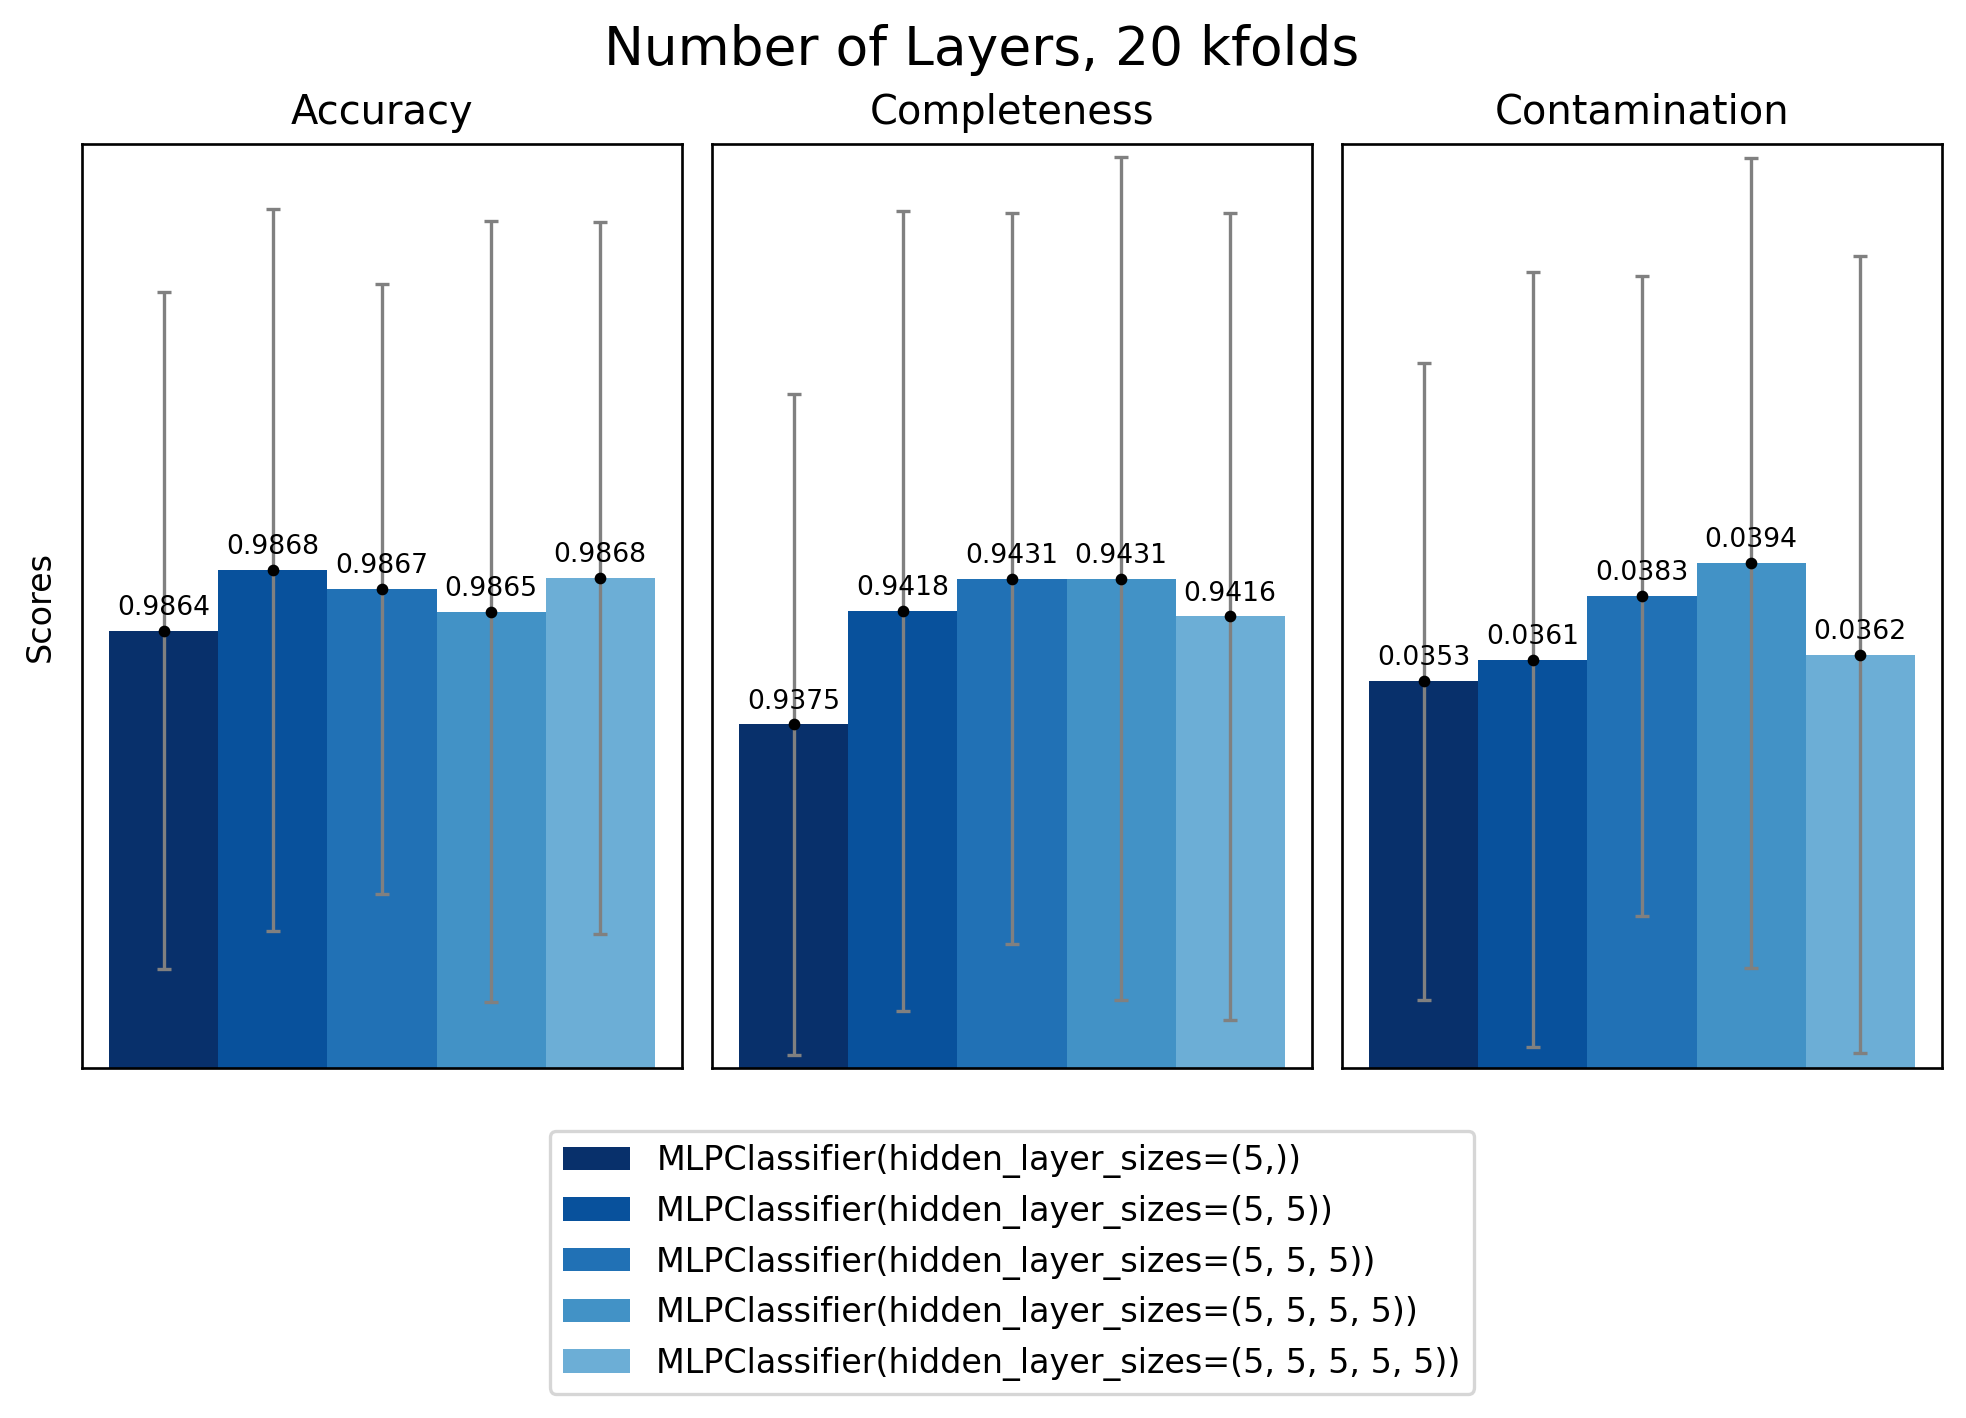

In [166]:

# ---------------Change colormap ----------------------------------------
cmap=plt.cm.Blues_r
c = cycler('color', cmap(np.linspace(0,0.5,len(info_list_nl))) )
plt.rcParams["axes.prop_cycle"] = c

# cmap=plt.cm.tab10
# c = cycler('color', cmap(range(10)))
# plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------

a_nl = compare_classifiers(info_list_nl, figtitle=f'Number of Layers, {kfolds} kfolds')


#### Activation function

In [100]:
mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

list = []

for act in ['logistic', 'tanh']:
    mlp_base_mod = clone(mlp_base)
    mlp_base_mod.set_params(activation=act)
    list.append(mlp_base_mod)
    
clf_list_act = [mlp_base, *list]

In [ ]:

info_list_act = run_classifier_list(clf_list_act, kfolds=20)

name  accuracy  completeness  \
2  MLPClassifier(activation='tanh', hidden_layer_...  0.986702      0.942648   
0             MLPClassifier(hidden_layer_sizes=(5,))  0.986213      0.936504   
1  MLPClassifier(activation='logistic', hidden_la...  0.985896      0.938756   

   contamination  
2       0.037896  
0       0.035487  
1       0.039822

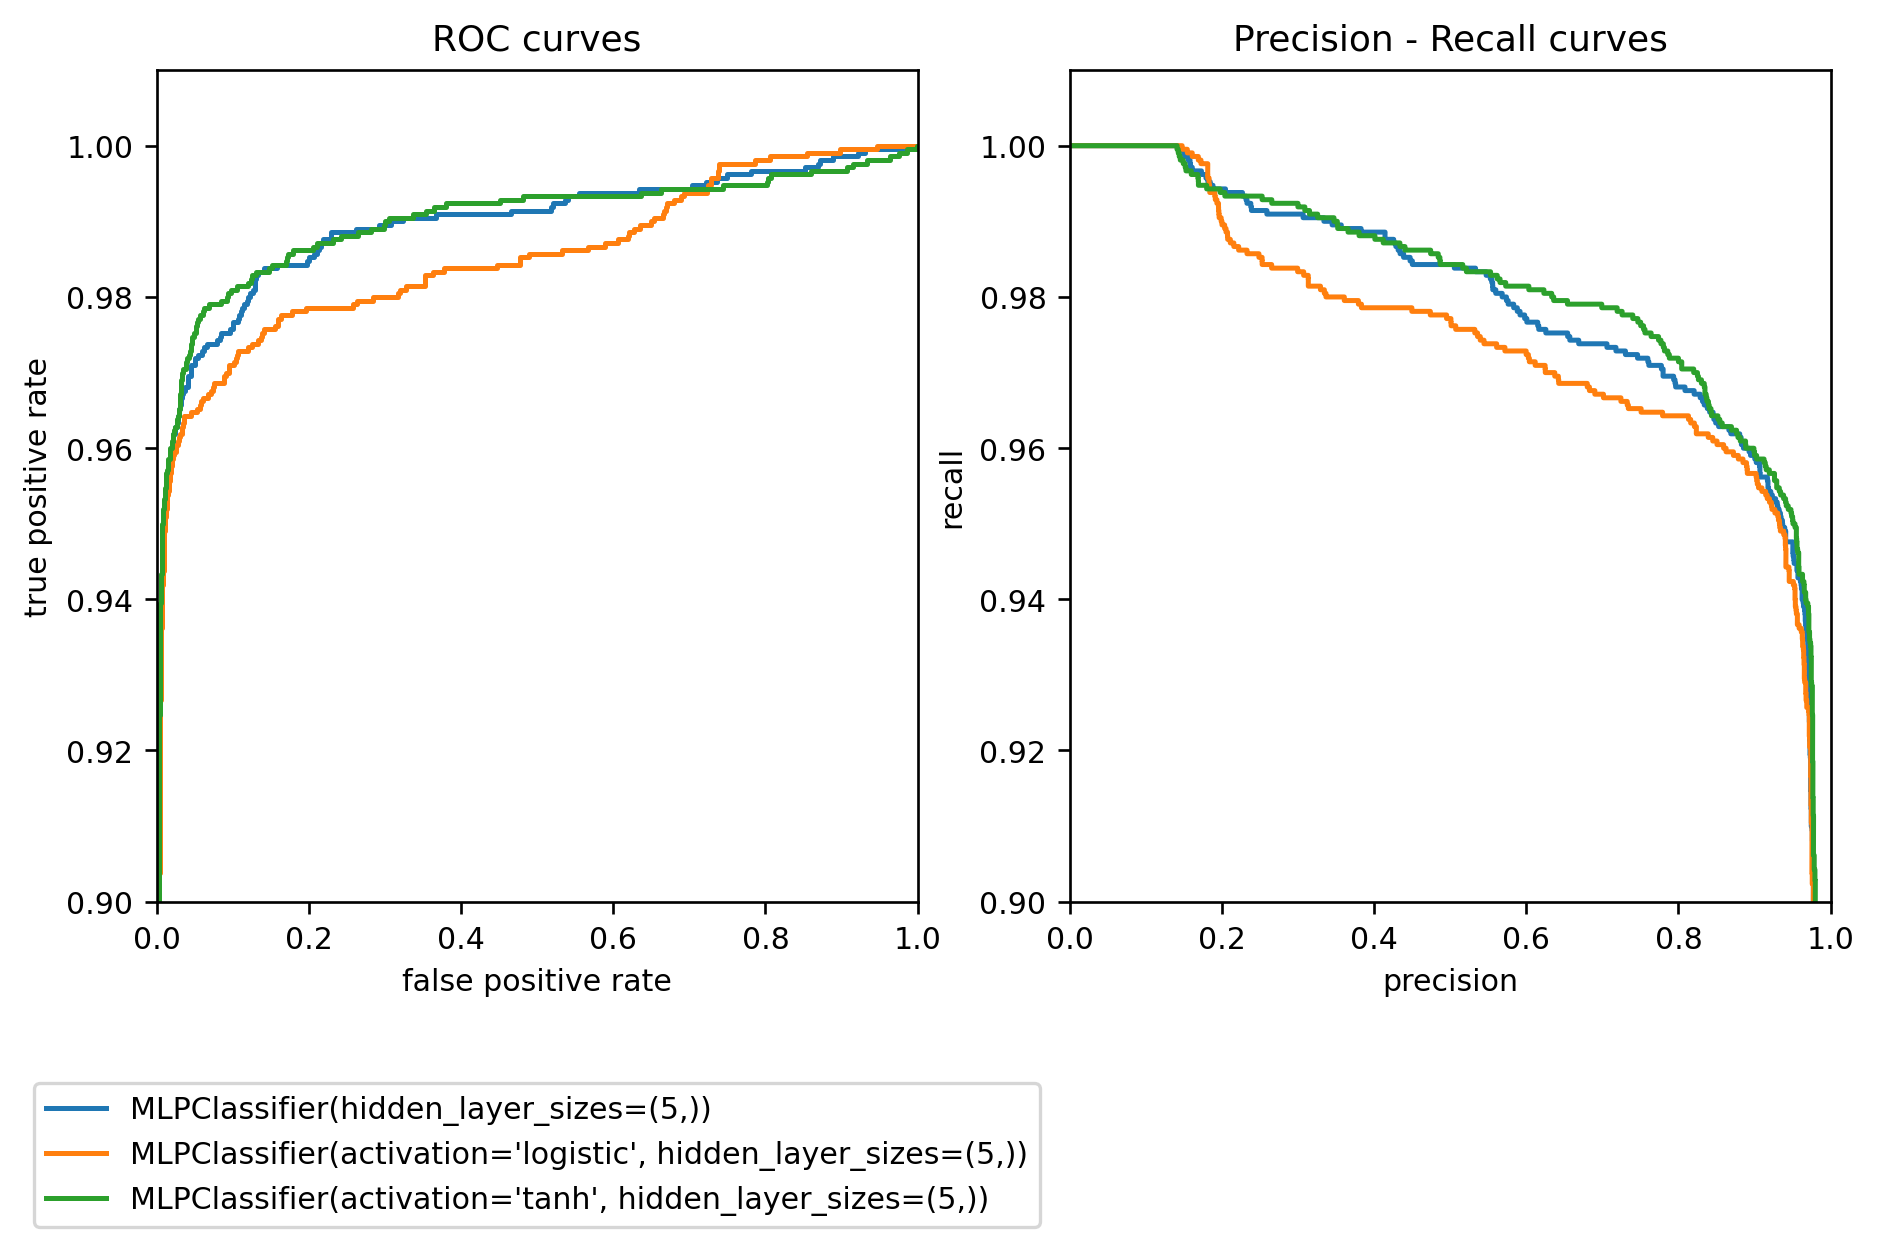

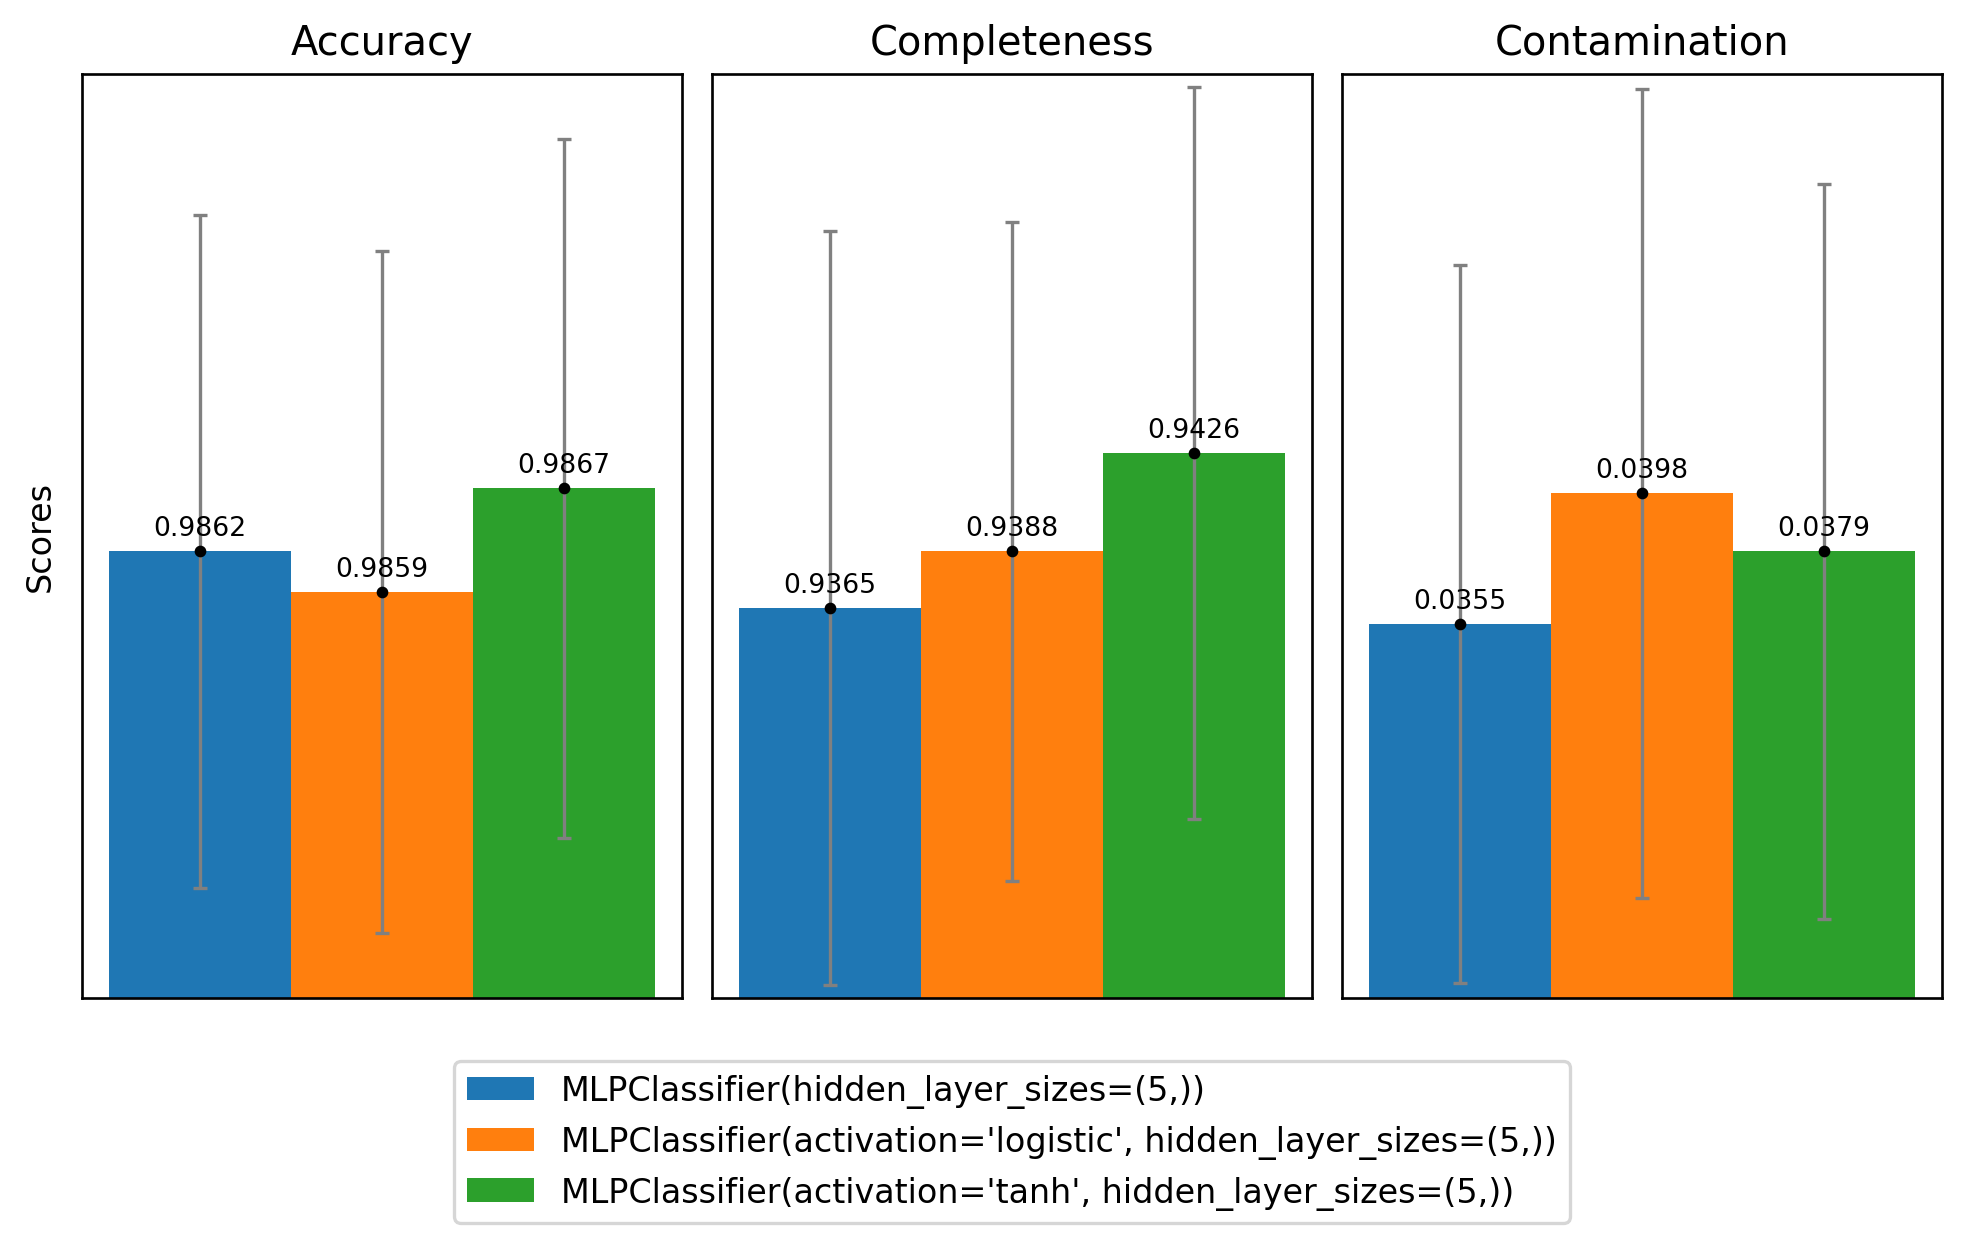

In [102]:

# ---------------Change colormap ----------------------------------------
# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list2))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------

a_act = compare_classifiers(info_list_act)


#### Learning rate behaviour


In [12]:
mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

list = []

for learnrate in ['invscaling', 'adaptive']:
    mlp_base_mod = clone(mlp_base)
    mlp_base_mod.set_params(learning_rate = learnrate)
    list.append(mlp_base_mod)
    
clf_list_learn = [mlp_base, *list]

In [ ]:
kfolds = 20
info_list_learn = run_classifier_list(clf_list_learn, kfolds=kfolds)

name  accuracy  completeness  \
0             MLPClassifier(hidden_layer_sizes=(5,))  0.986472      0.938551   
2  MLPClassifier(hidden_layer_sizes=(5,), learnin...  0.986385      0.937529   
1  MLPClassifier(hidden_layer_sizes=(5,), learnin...  0.986328      0.937939   

   contamination  
0       0.035586  
2       0.035297  
1       0.036044

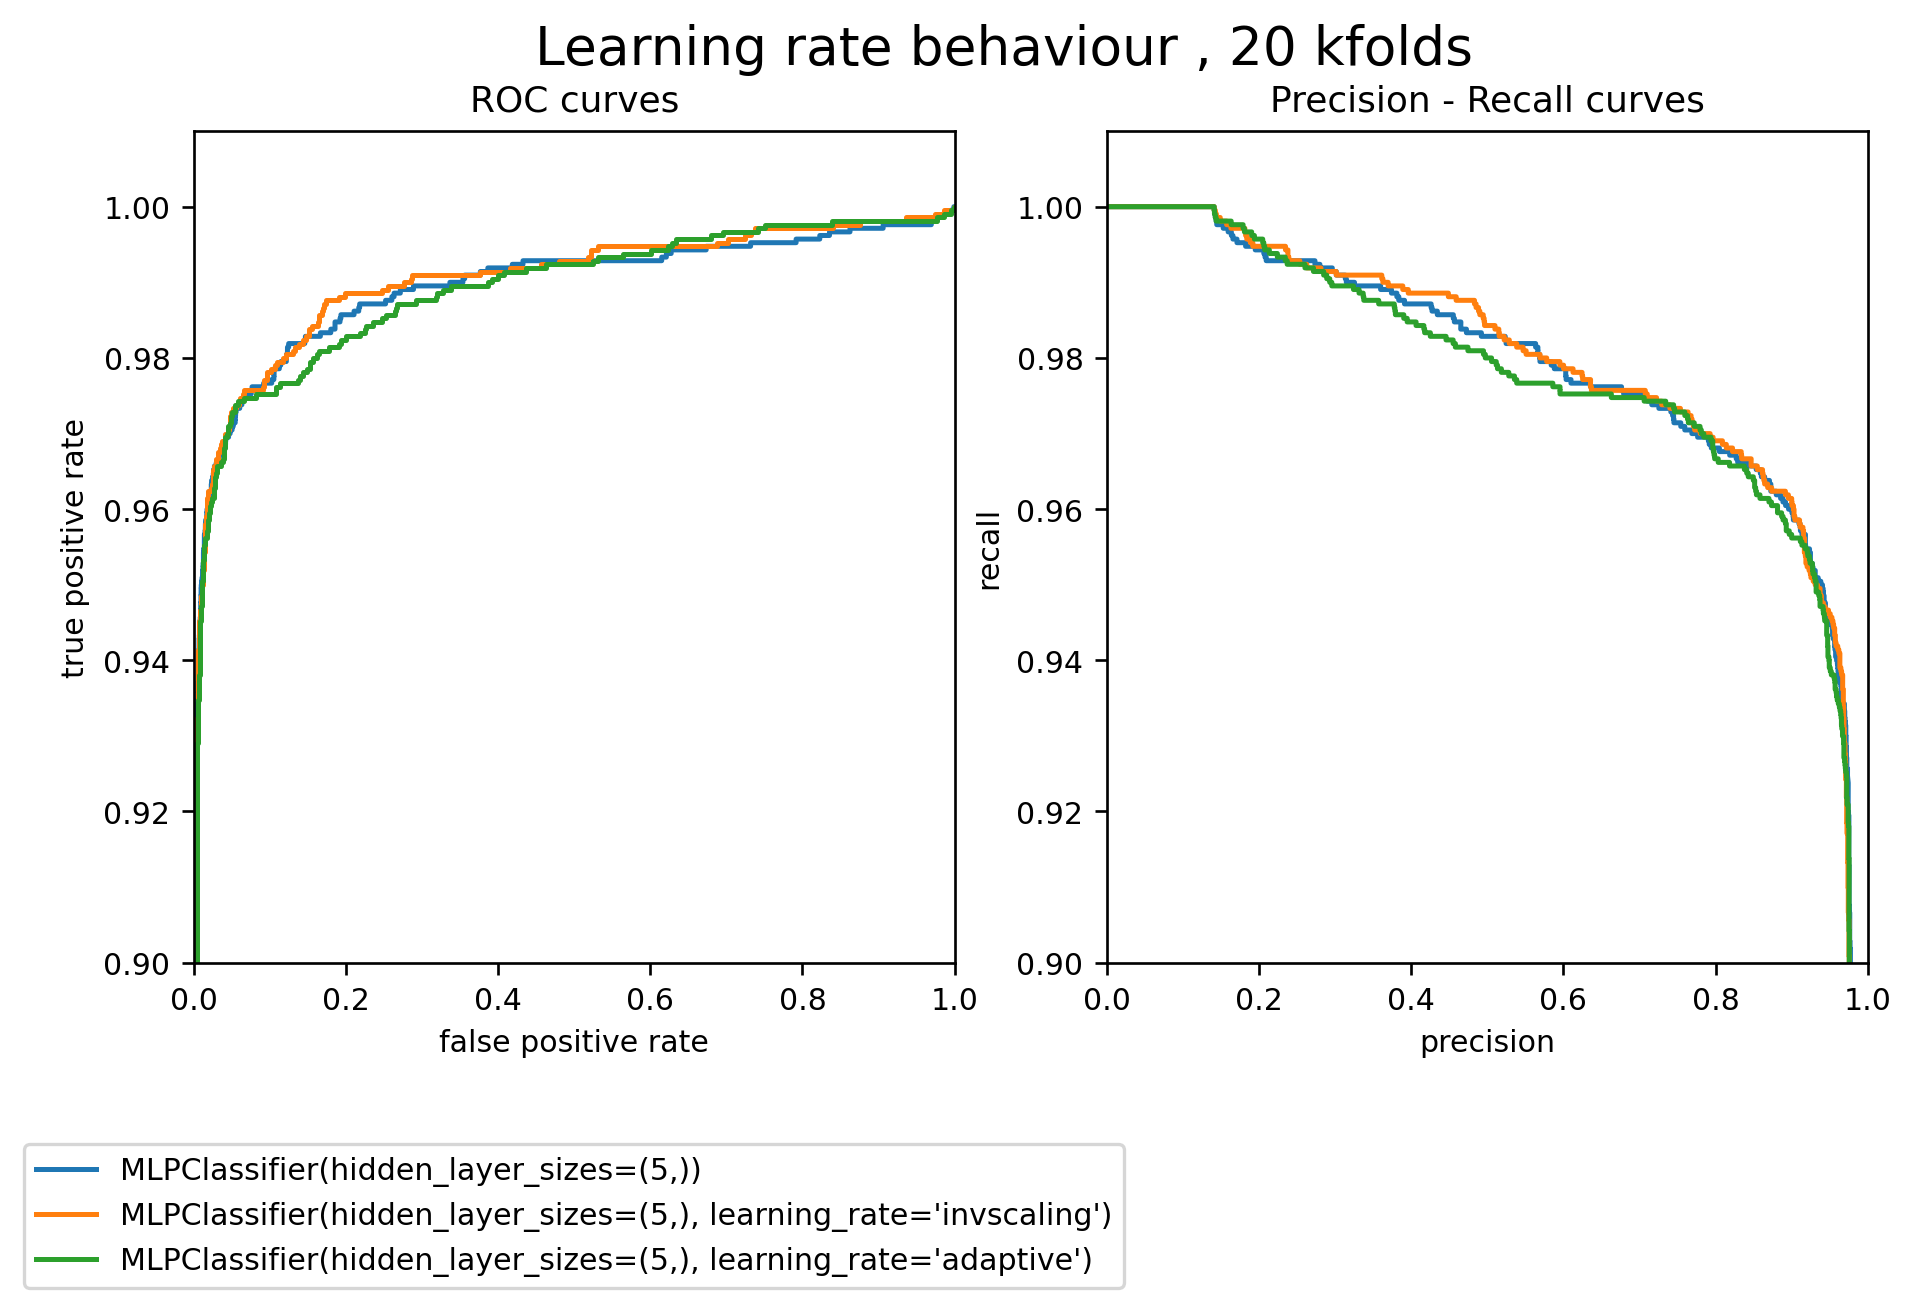

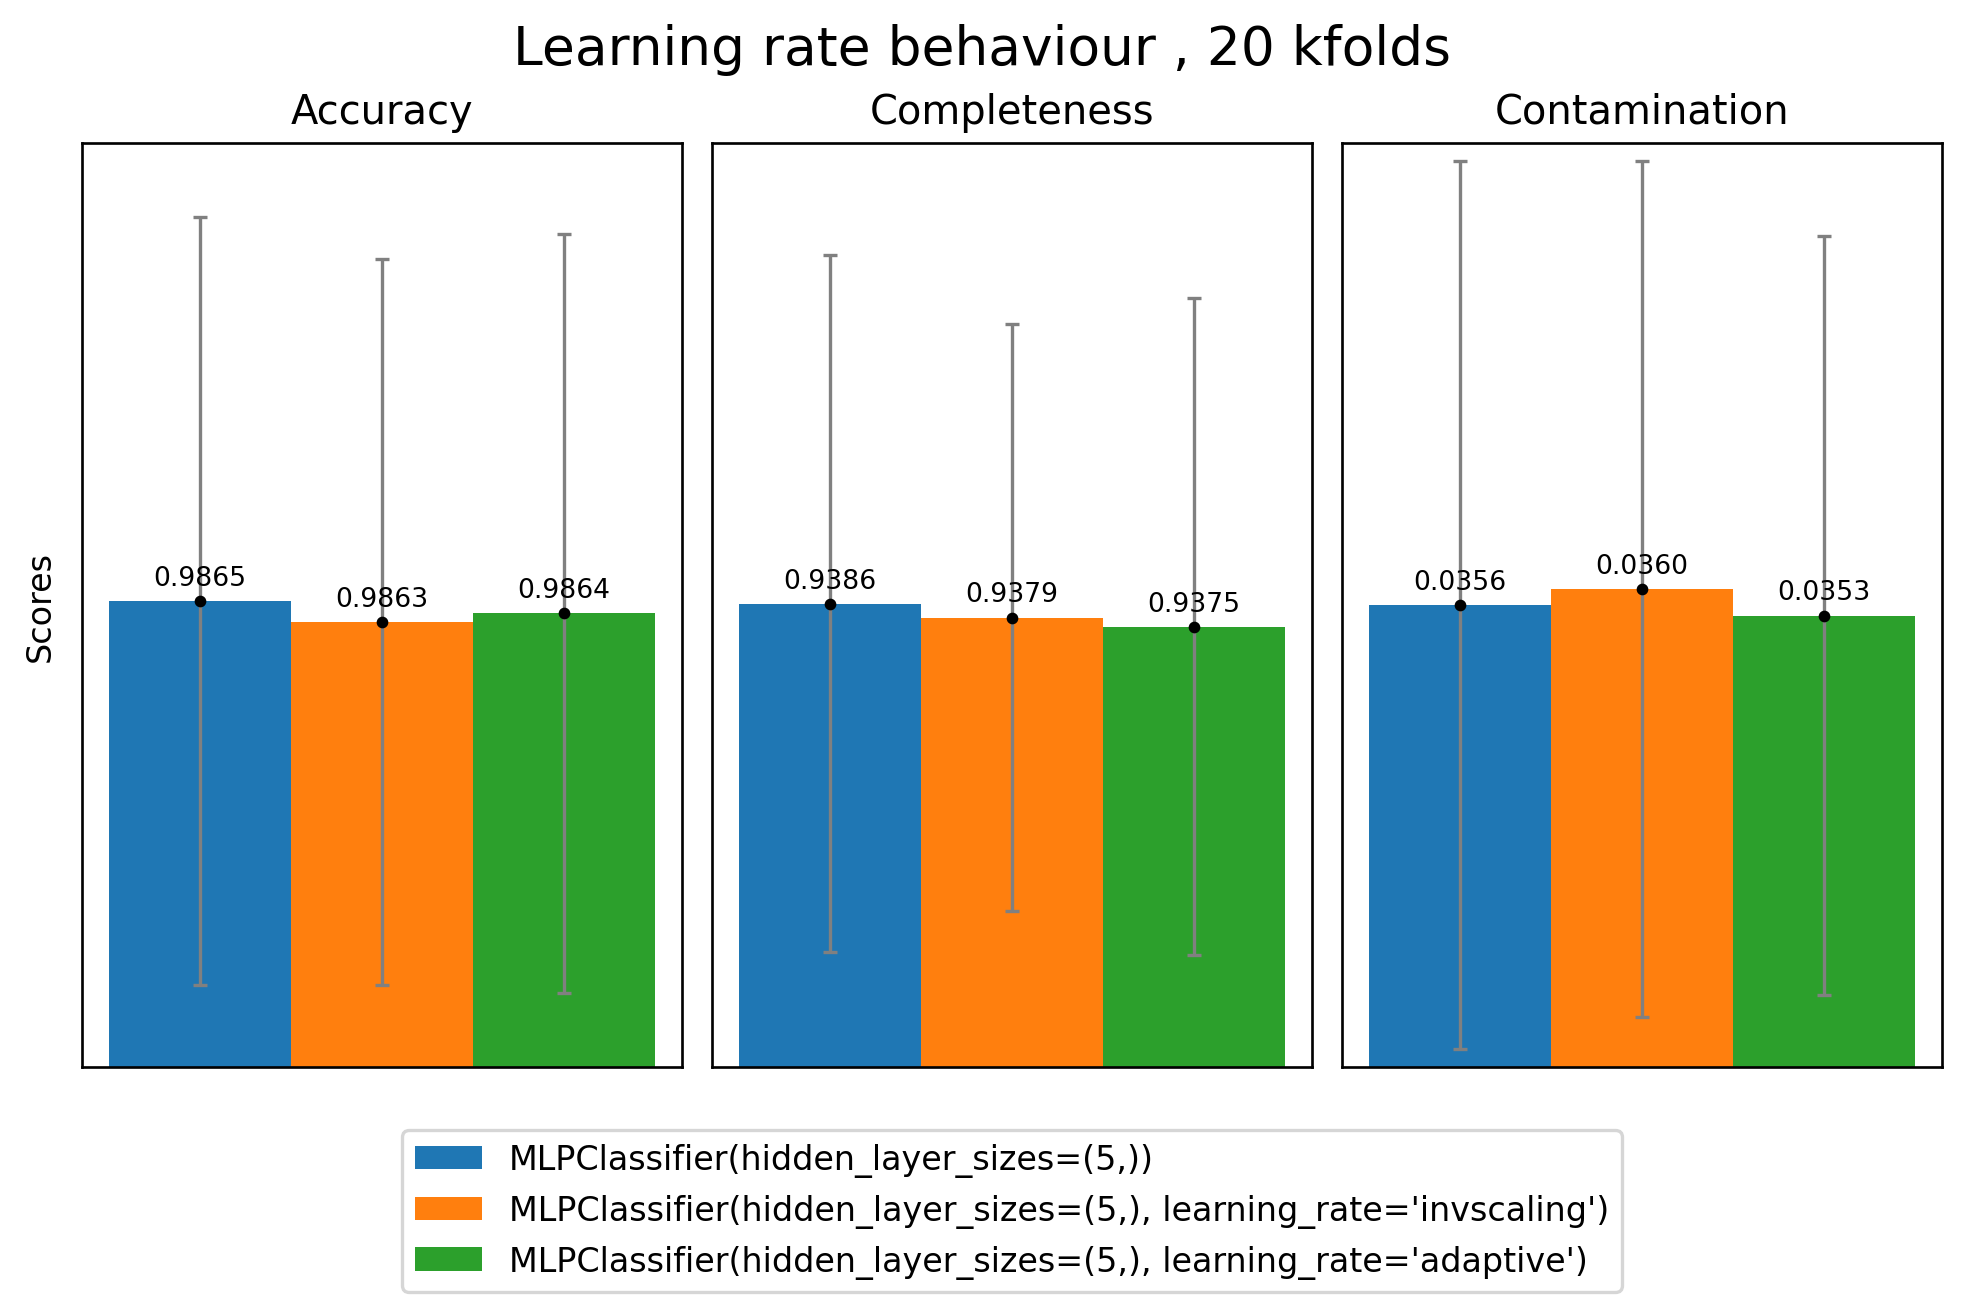

In [14]:
# ---------------Change colormap ----------------------------------------
# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list2))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------

a_learn = compare_classifiers(info_list_learn, figtitle=f'Learning rate behaviour , {kfolds} kfolds')


## Data augmentation

We try to feed tranformed data to the network to see if classification performance improves.

In [120]:
X = data_clean
y = lab_clean

# DIfferent transformations
X_square =  np.power(X, 2)
X_cube = np.power(X, 3)

X_aug = np.concatenate((X, X_square, X_cube), axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_aug, y,  test_size=0.3, random_state=0)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train_a = scaler.fit_transform(X_train_a)
X_test_a = scaler.transform(X_test_a)

X_train_original = X_train_a[:, 0:4]
X_test_original = X_test_a[:, 0:4]



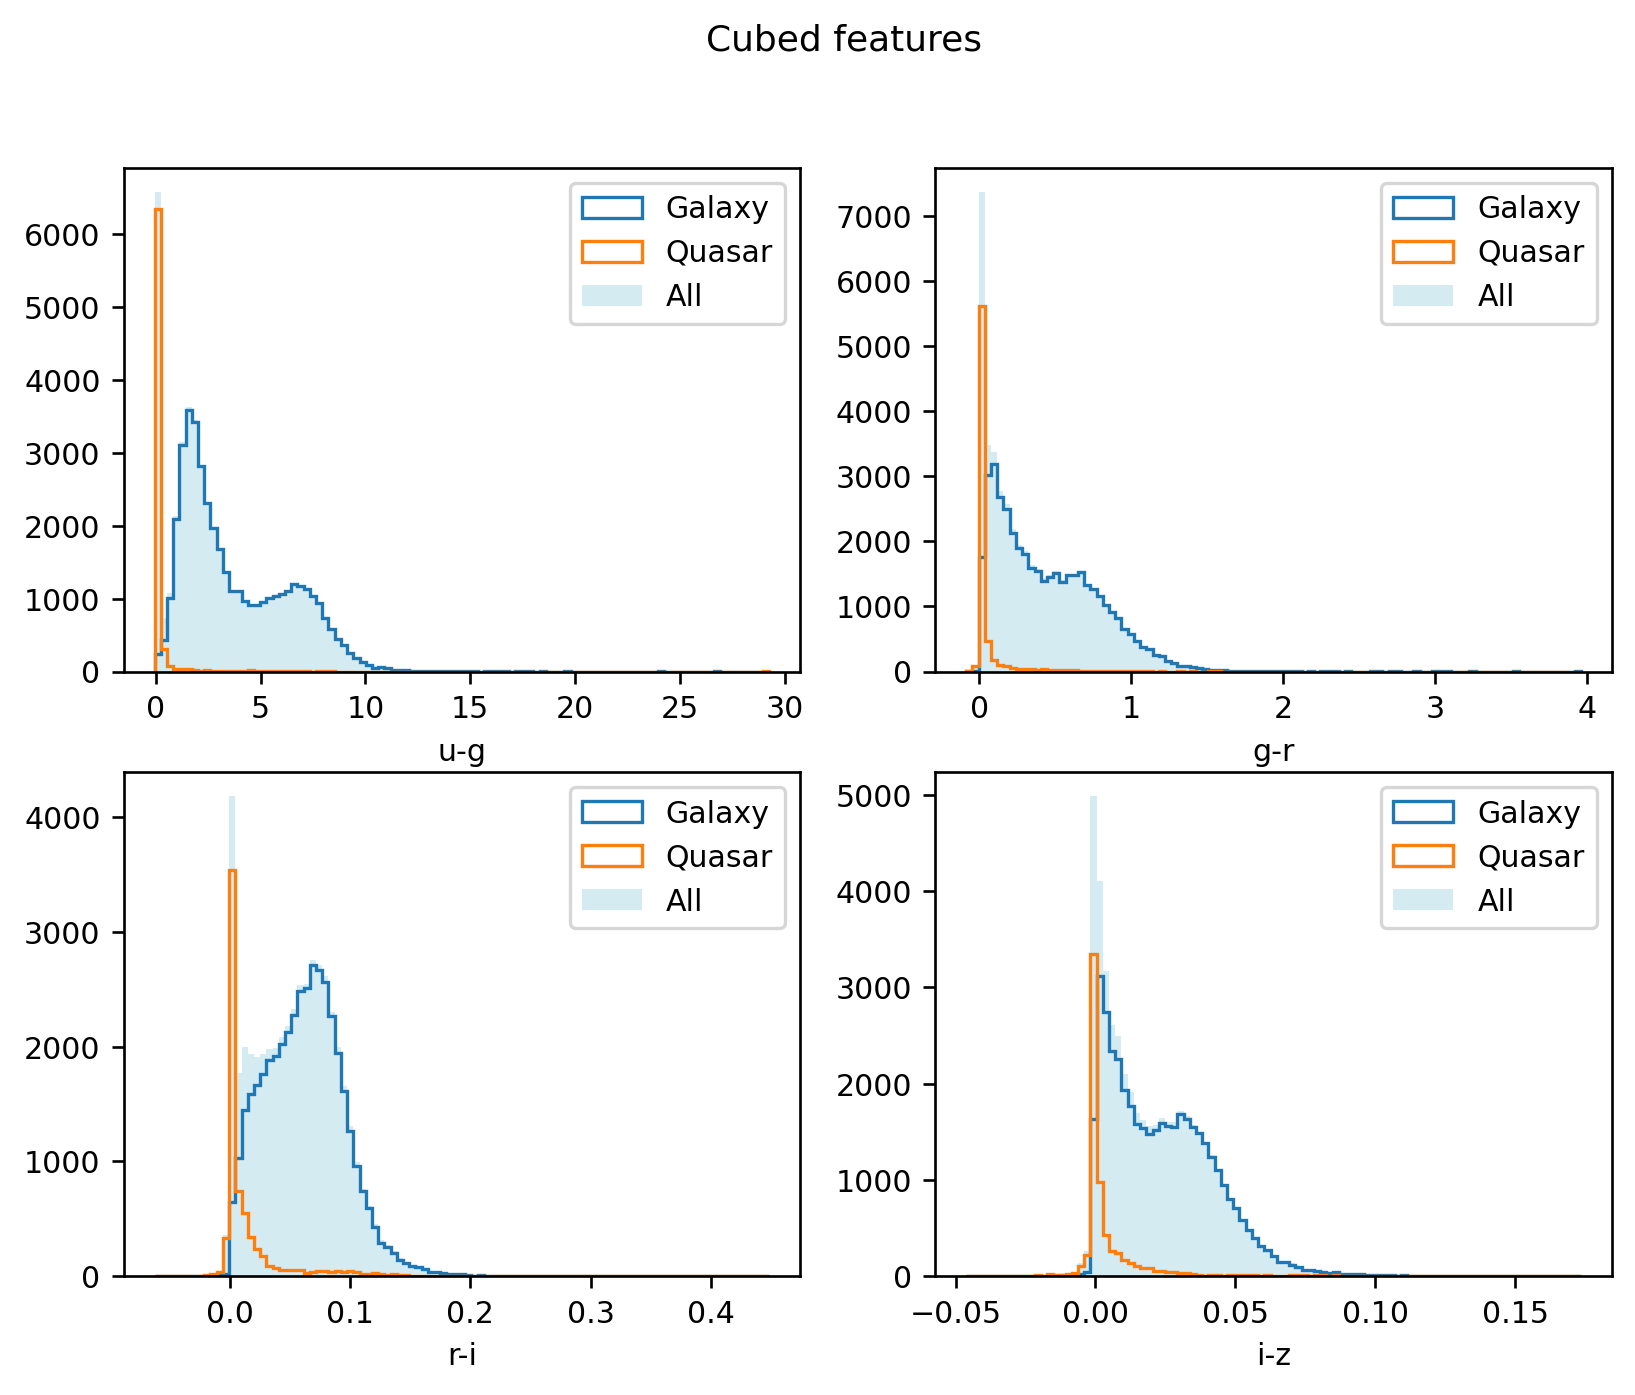

In [122]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)
fig.suptitle('Cubed features')

for ax,color, name in zip(axs.flatten() ,X_cube.T,names):
    
    bins = np.linspace(np.min(color), np.max(color), 100)   
    gala = color[y==0]
    quas = color[y==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    # ax.set_yscale('log')
    
plt.tight_layout;

In [149]:

# USEFUL FUNCTIONS FOR AUG DATA
###################################################

def run_classifier_AUG(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
        
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    
    Kwargs: 
    
    proba = True, can be set to False if the classifier doeas not have predict_proba() method (like SVC).
    name = 'custom_name' , to use custom name.
    test_set = False , can be set to True to compute metrics on the test set.
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    # Setting default kwargs
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    test_metrics = kwargs.get('test_metrics', False)
    kfolds = kwargs.get('kfolds', 5)
    
    print(f'Fitting {name}')

    clf.fit(X_train_a, y_train_a) # Fit classifier
    
    if proba == False:
        y_probs = clf.decision_function(X_test_a)
    else:
        y_probs = clf.predict_proba(X_test_a)[:, 1]
        
    y_pred = clf.predict(X_test_a)
    
    #-------------------------------------------------------------------------------
    if test_metrics == True:
        complet = recall_score(y_test_a, y_pred)
        contam = 1 - precision_score(y_test_a, y_pred)
        accur = accuracy_score(y_test_a, y_pred)
        sigmas = np.array([.0,.0, .0])
    else:
        score_list = ['accuracy', 'recall', 'precision' ]
        cv_results = cross_validate(clf, X_train_a, y_train_a, scoring = score_list, 
                                    n_jobs=-1, verbose=1, cv=kfolds )

        accur = np.mean(cv_results['test_accuracy'])
        accur_sigma = np.std(cv_results['test_accuracy'])
        complet = np.mean(cv_results['test_recall'])
        complet_sigma = np.std(cv_results['test_recall'])
        contam = np.mean(1 - cv_results['test_precision'])
        contam_sigma = np.std(1 - cv_results['test_precision'])
        
        sigmas = np.array([accur_sigma, complet_sigma, contam_sigma])
        
    #-------------------------------------------------------------------------------    
    
    metrics = np.array([accur, complet, contam])
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves, sigmas]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list_AUG (classifiers_list, **kwargs):
    '''
    DO NOT USE WITH SVC etc (without .predict_proba() method): use run_classifier() on the single clf and then append info manually
    
    Trains and evalutate performance of a list of classifiers
   
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function
    
    kwargs:
    names = ['name1','name2',..] , to use custom name list for classifiers
    test_metrics =False , can be set to True to compute metrics on the test set
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    test_metrics = kwargs.get('test_metrics',False)
    kfolds = kwargs.get('kfolds', 5)
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier_AUG(clf, name=name, test_metrics=test_metrics, kfolds=kfolds ))
    return info_list

###################################################


We train a base MLP with architecture (10,5) with the original data, and use augmented data to train some other classifiers with different architectures

In [184]:
# Define classifiers

mlp_base = MLPClassifier(
                    hidden_layer_sizes=(10,5),
                    solver='adam', 
                    activation = 'relu')

mlp_aug = MLPClassifier(
                    hidden_layer_sizes=(10,5),
                    solver='adam', 
                    activation = 'relu')

mlp_aug2 = MLPClassifier(
                    hidden_layer_sizes=(50,10),
                    solver='adam', 
                    activation = 'relu')

mlp_aug3 = MLPClassifier(
                    hidden_layer_sizes=(80,20, 5),
                    solver='adam', 
                    activation = 'relu')

mlp_aug4 = MLPClassifier(
                    hidden_layer_sizes=(80,20),
                    solver='adam', 
                    activation = 'relu')

clf_list_aug = [mlp_base, mlp_aug, mlp_aug2, mlp_aug3, mlp_aug4]


In [ ]:
kfolds = 20
info_base = run_classifier(mlp_base, kfolds=kfolds, name='Original dataset')
info_aug = run_classifier_AUG(mlp_aug, kfolds=kfolds, name='Augmented dataset')
info_aug2 = run_classifier_AUG(mlp_aug2, kfolds=kfolds, name='Augmented dataset 2')
info_aug3 = run_classifier_AUG(mlp_aug3, kfolds=kfolds, name='Augmented dataset 3')

In [185]:
info_aug4 = run_classifier_AUG(mlp_aug4, kfolds=kfolds, name='Augmented dataset 4')
info_list_aug = [info_base, info_aug, info_aug2, info_aug3, info_aug4 ]

Fitting Augmented dataset 3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.0min finished


name  accuracy  completeness  contamination
2  Augmented dataset 2  0.987422      0.947360       0.037270
4  Augmented dataset 3  0.987278      0.947156       0.038043
3  Augmented dataset 3  0.987278      0.944287       0.035413
1    Augmented dataset  0.986875      0.947383       0.040749
0     Original dataset  0.986788      0.942474       0.036717

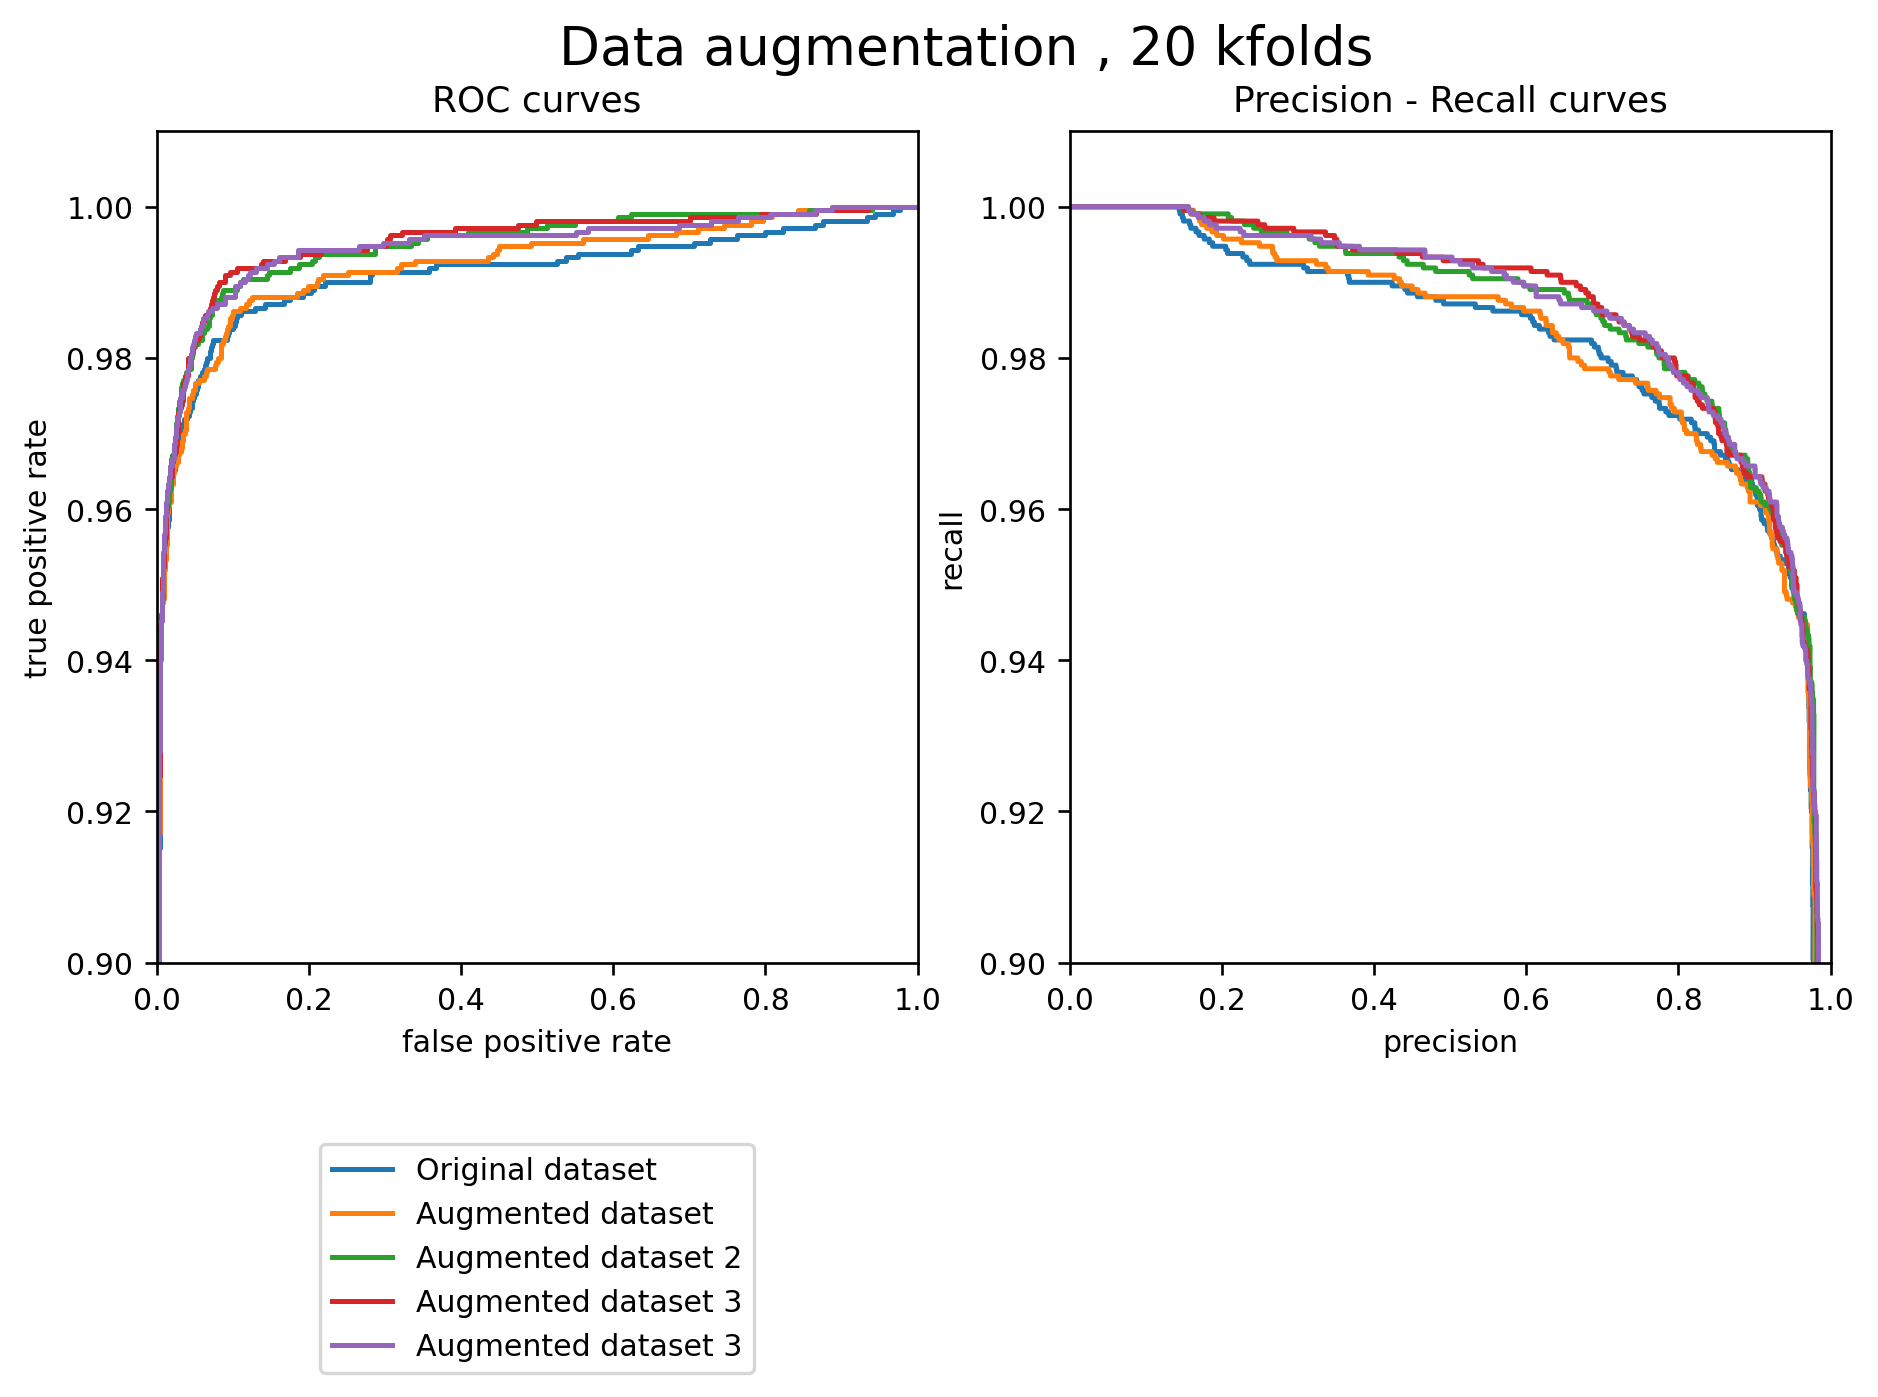

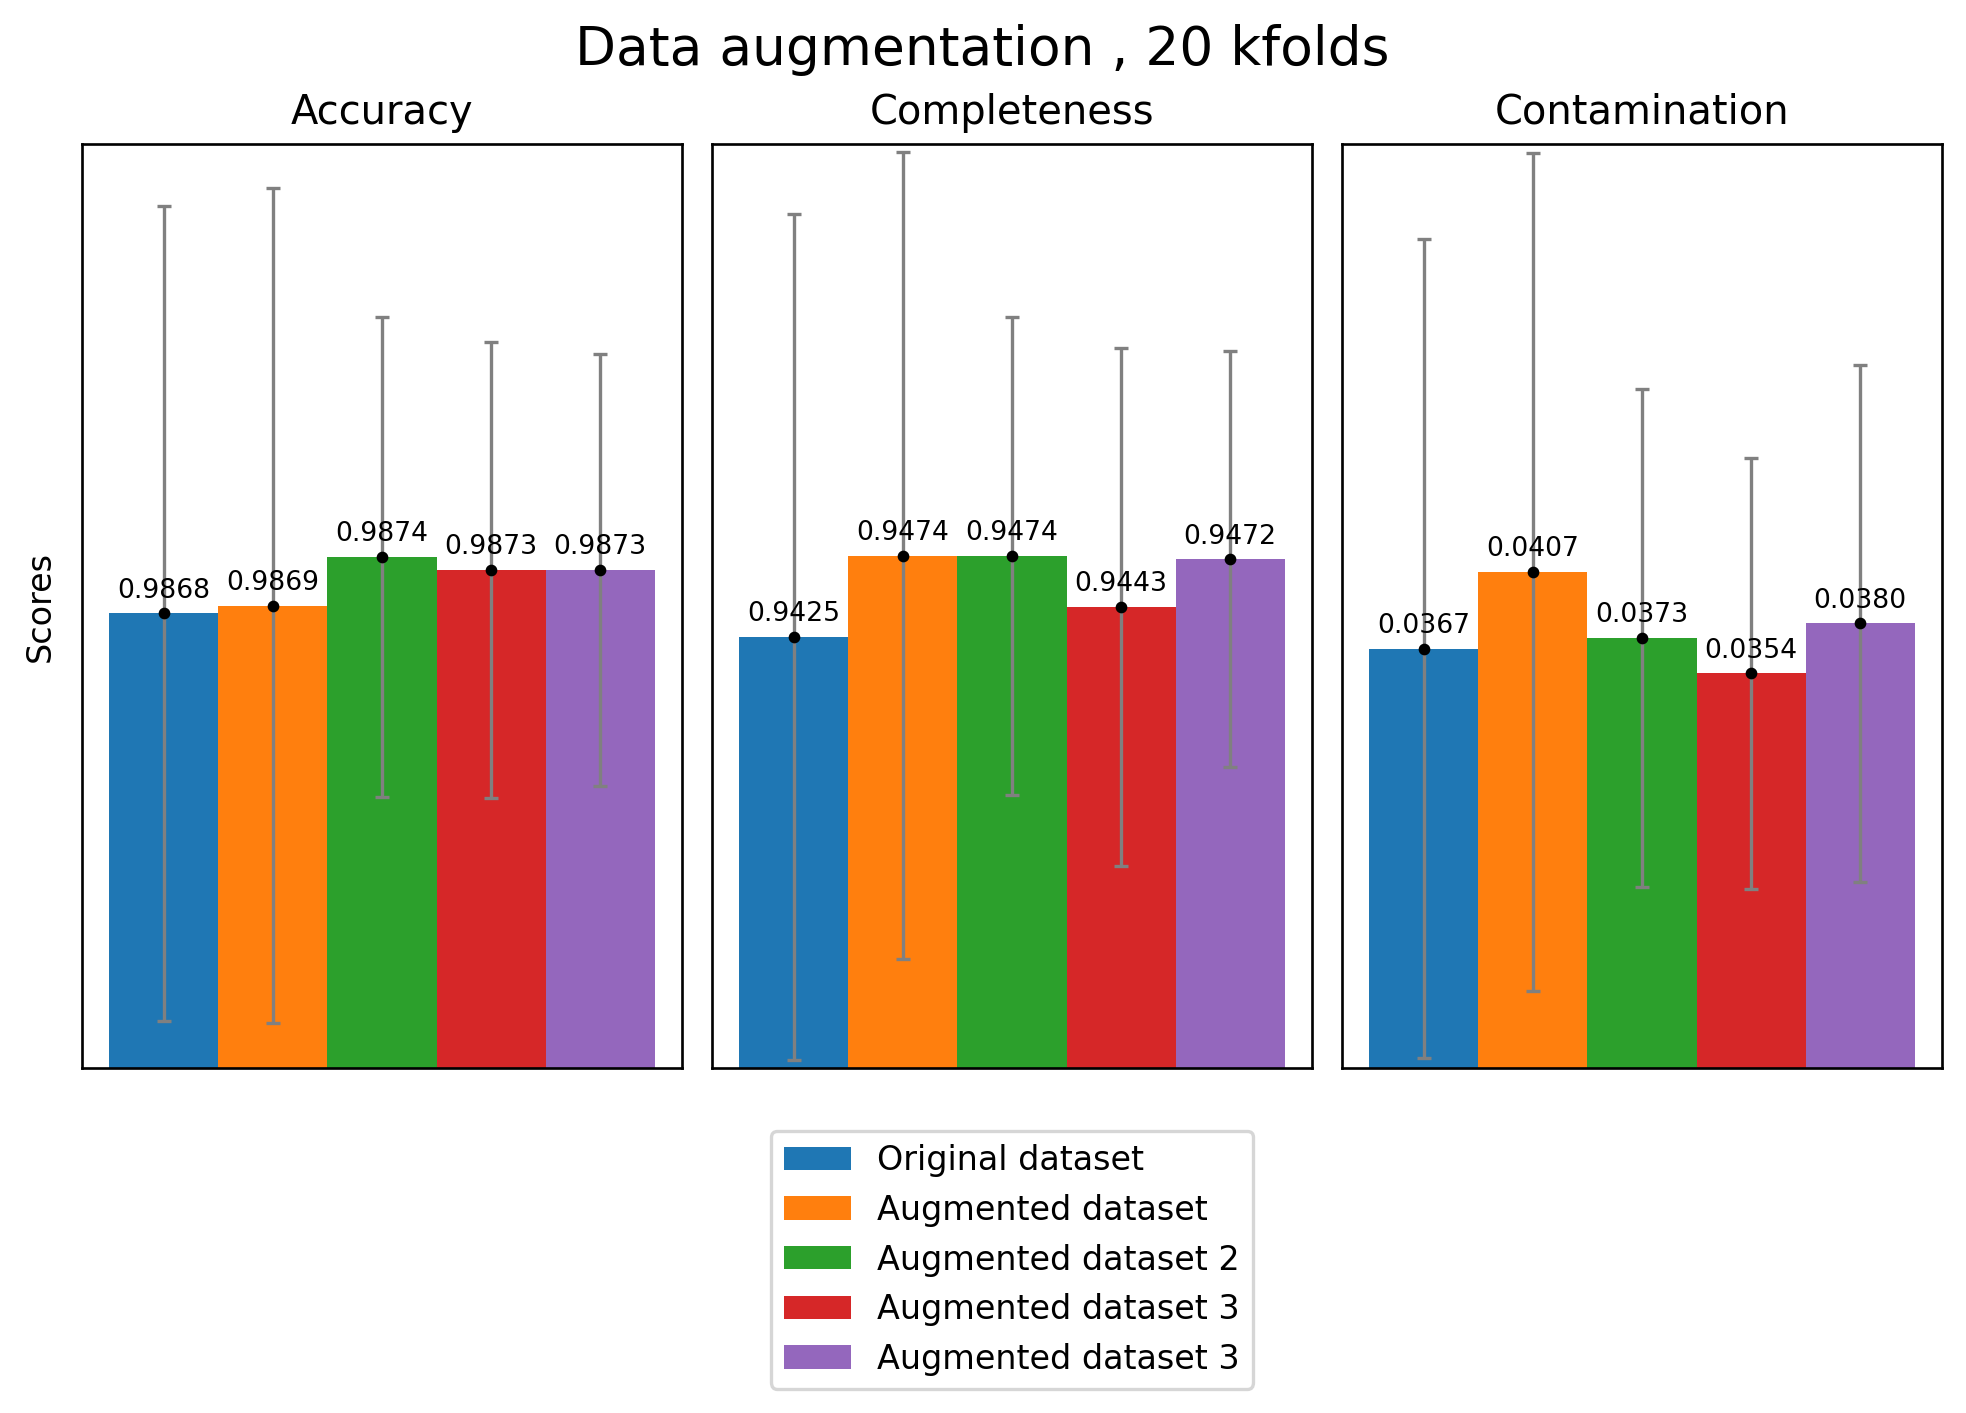

In [186]:
# ---------------Change colormap ----------------------------------------
# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list2))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------
a_aug = compare_classifiers(info_list_aug, figtitle=f'Data augmentation , {kfolds} kfolds')

## Final comparison
Let's try to combine all improvements.

We want to explore:
- Architecture: (5), (100), (50,20)
- Activation: relu, tanh
- Dataset: original, augmented

We will do a cycle of 40-fold CV to see how they perform on the train test, and then we will compute performance metrics on the test set.

In [220]:
# Original dataset
mlp_o1 = MLPClassifier(solver='adam', hidden_layer_sizes=(5), activation='relu')
mlp_o2 = MLPClassifier(solver='adam', hidden_layer_sizes=(100), activation='relu')
mlp_o3 = MLPClassifier(solver='adam', hidden_layer_sizes=(50,20), activation='relu')
mlp_o4 = MLPClassifier(solver='adam', hidden_layer_sizes=(5), activation='tanh')
mlp_o5 = MLPClassifier(solver='adam', hidden_layer_sizes=(100), activation='tanh')
mlp_o6 = MLPClassifier(solver='adam', hidden_layer_sizes=(50,20), activation='tanh')

# Augmented dataset
mlp_a1 = MLPClassifier(solver='adam', hidden_layer_sizes=(5), activation='relu')
mlp_a2 = MLPClassifier(solver='adam', hidden_layer_sizes=(100), activation='relu')
mlp_a3 = MLPClassifier(solver='adam', hidden_layer_sizes=(50,20), activation='relu')
mlp_a4 = MLPClassifier(solver='adam', hidden_layer_sizes=(5), activation='tanh')
mlp_a5 = MLPClassifier(solver='adam', hidden_layer_sizes=(100), activation='tanh')
mlp_a6 = MLPClassifier(solver='adam', hidden_layer_sizes=(50,20), activation='tanh')

clf_list_original =[ mlp_o1,
                                    mlp_o2,
                                    mlp_o3,
                                    mlp_o4,
                                    mlp_o5,
                                    mlp_o6 ]

clf_list_augmented =[ mlp_a1,
                                            mlp_a2,
                                            mlp_a3,
                                            mlp_a4,
                                            mlp_a5,
                                            mlp_a6 ]

In [ ]:
kfolds = 40
info_list_original = run_classifier_list(clf_list_original, kfolds=kfolds)

In [ ]:
kfolds = 40
info_list_augmented = run_classifier_list_AUG(clf_list_augmented, kfolds=kfolds)

name  accuracy  completeness  \
7               MLPClassifier(hidden_layer_sizes=100)  0.987508      0.947164   
10  MLPClassifier(activation='tanh', hidden_layer_...  0.987422      0.946138   
11  MLPClassifier(activation='tanh', hidden_layer_...  0.987191      0.945727   
5   MLPClassifier(activation='tanh', hidden_layer_...  0.987191      0.946341   
8          MLPClassifier(hidden_layer_sizes=(50, 20))  0.987134      0.947571   
2          MLPClassifier(hidden_layer_sizes=(50, 20))  0.987076      0.944504   
9   MLPClassifier(activation='tanh', hidden_layer_...  0.987076      0.945735   
4   MLPClassifier(activation='tanh', hidden_layer_...  0.987047      0.944096   
1               MLPClassifier(hidden_layer_sizes=100)  0.986904      0.943479   
3   MLPClassifier(activation='tanh', hidden_layer_...  0.986788      0.943684   
6                 MLPClassifier(hidden_layer_sizes=5)  0.986760      0.943887   
0                 MLPClassifier(hidden_layer_sizes=5)  0.986242      0.934886   

    contamination  
7        0.036376  
10       0.035985  
11       0.037136  
5        0.037681  
8        0.039180  
2        0.036835  
9        0.037991  
4        0.036609  
1        0.037025  
3        0.038093  
6        0.038406  
0        0.033631

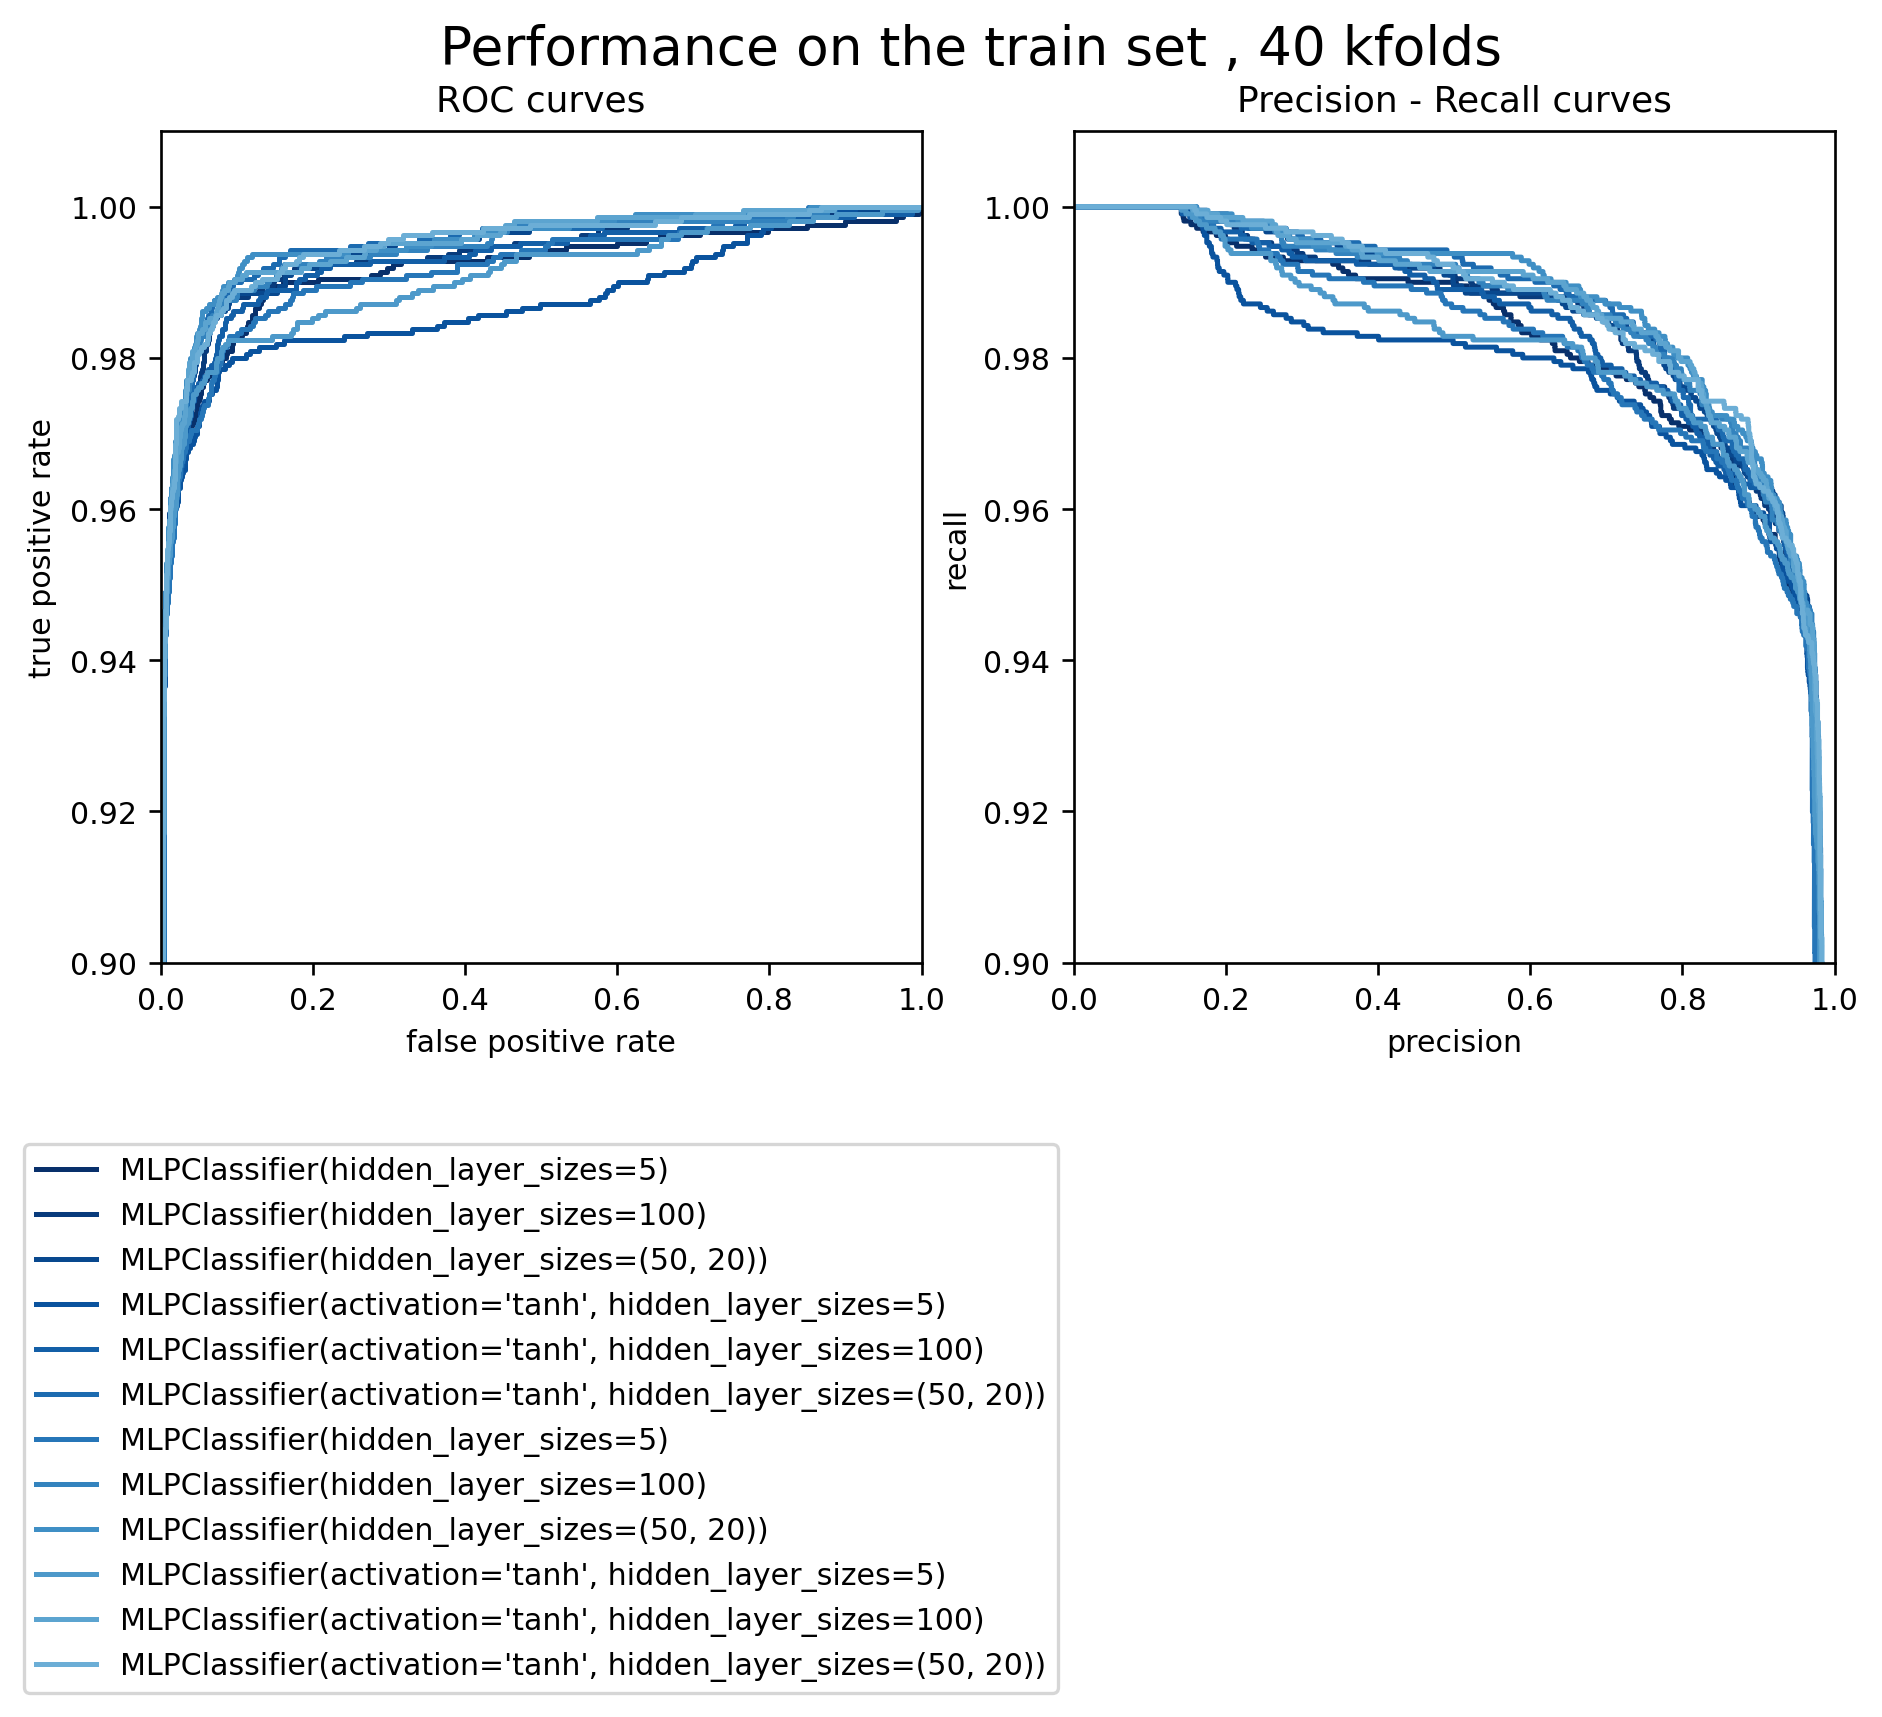

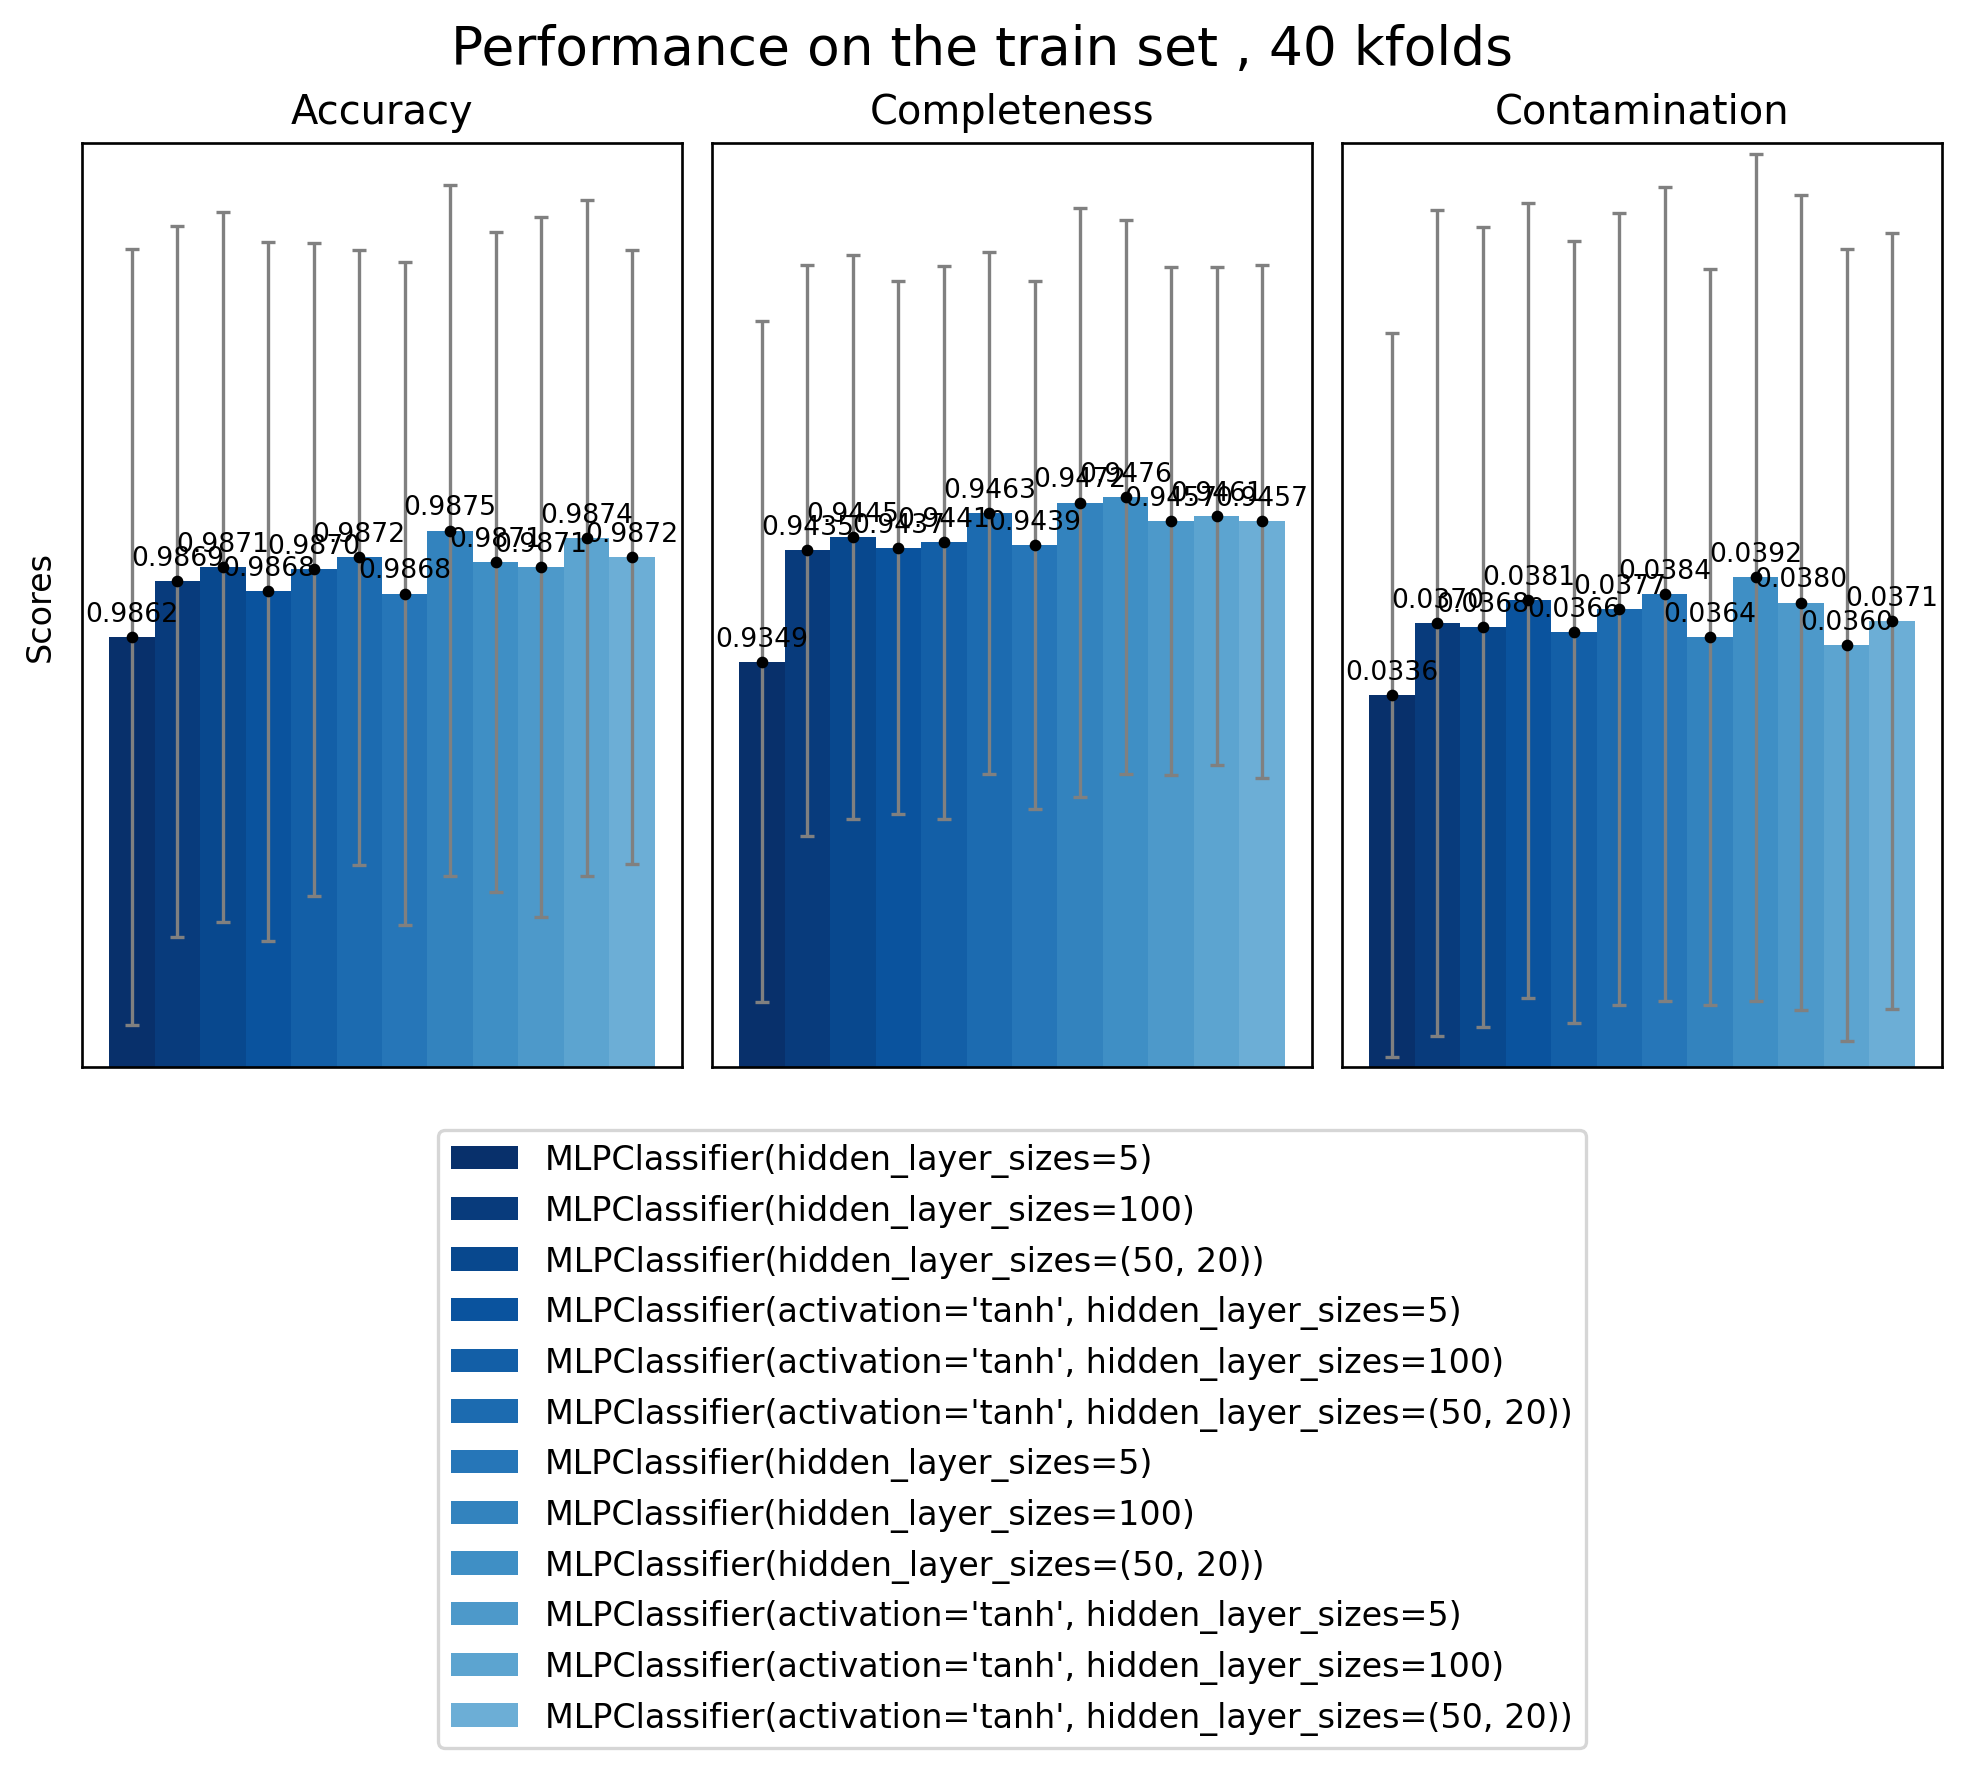

In [255]:
info_list_tot = info_list_original + info_list_augmented

# ---------------Change colormap ----------------------------------------
cmap=plt.cm.Blues_r
c = cycler('color', cmap(np.linspace(0,0.5,len(info_list_tot))) )
plt.rcParams["axes.prop_cycle"] = c

# cmap=plt.cm.tab10
# c = cycler('color', cmap(range(10)))
# plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------
a_final = compare_classifiers(info_list_tot, figtitle=f'Performance on the train set , {kfolds} kfolds')

Now we compute perfomance metrics on the test set:

In [257]:
info_list_original_test = run_classifier_list(clf_list_original, test_metrics = True)
info_list_augmented_test = run_classifier_list_AUG(clf_list_augmented, test_metrics = True)

Fitting MLPClassifier(hidden_layer_sizes=5)
Fitting MLPClassifier(hidden_layer_sizes=100)
Fitting MLPClassifier(hidden_layer_sizes=(50, 20))
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=5)
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=100)
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 20))
Fitting MLPClassifier(hidden_layer_sizes=5)
Fitting MLPClassifier(hidden_layer_sizes=100)
Fitting MLPClassifier(hidden_layer_sizes=(50, 20))
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=5)
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=100)
Fitting MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 20))


name  accuracy  completeness  \
4   MLPClassifier(activation='tanh', hidden_layer_...  0.987911      0.943783   
10  MLPClassifier(activation='tanh', hidden_layer_...  0.987777      0.946641   
1               MLPClassifier(hidden_layer_sizes=100)  0.987710      0.941877   
7               MLPClassifier(hidden_layer_sizes=100)  0.987441      0.945212   
11  MLPClassifier(activation='tanh', hidden_layer_...  0.987374      0.941877   
5   MLPClassifier(activation='tanh', hidden_layer_...  0.987307      0.941877   
2          MLPClassifier(hidden_layer_sizes=(50, 20))  0.987173      0.944259   
3   MLPClassifier(activation='tanh', hidden_layer_...  0.987173      0.944736   
6                 MLPClassifier(hidden_layer_sizes=5)  0.987105      0.941401   
8          MLPClassifier(hidden_layer_sizes=(50, 20))  0.987038      0.938542   
0                 MLPClassifier(hidden_layer_sizes=5)  0.986635      0.936160   
9   MLPClassifier(activation='tanh', hidden_layer_...  0.986434      0.943306   

    contamination  
4        0.030348  
10       0.034030  
1        0.029931  
7        0.035019  
11       0.032305  
5        0.032779  
2        0.035992  
3        0.036443  
6        0.033741  
8        0.031465  
0        0.032020  
9        0.040233

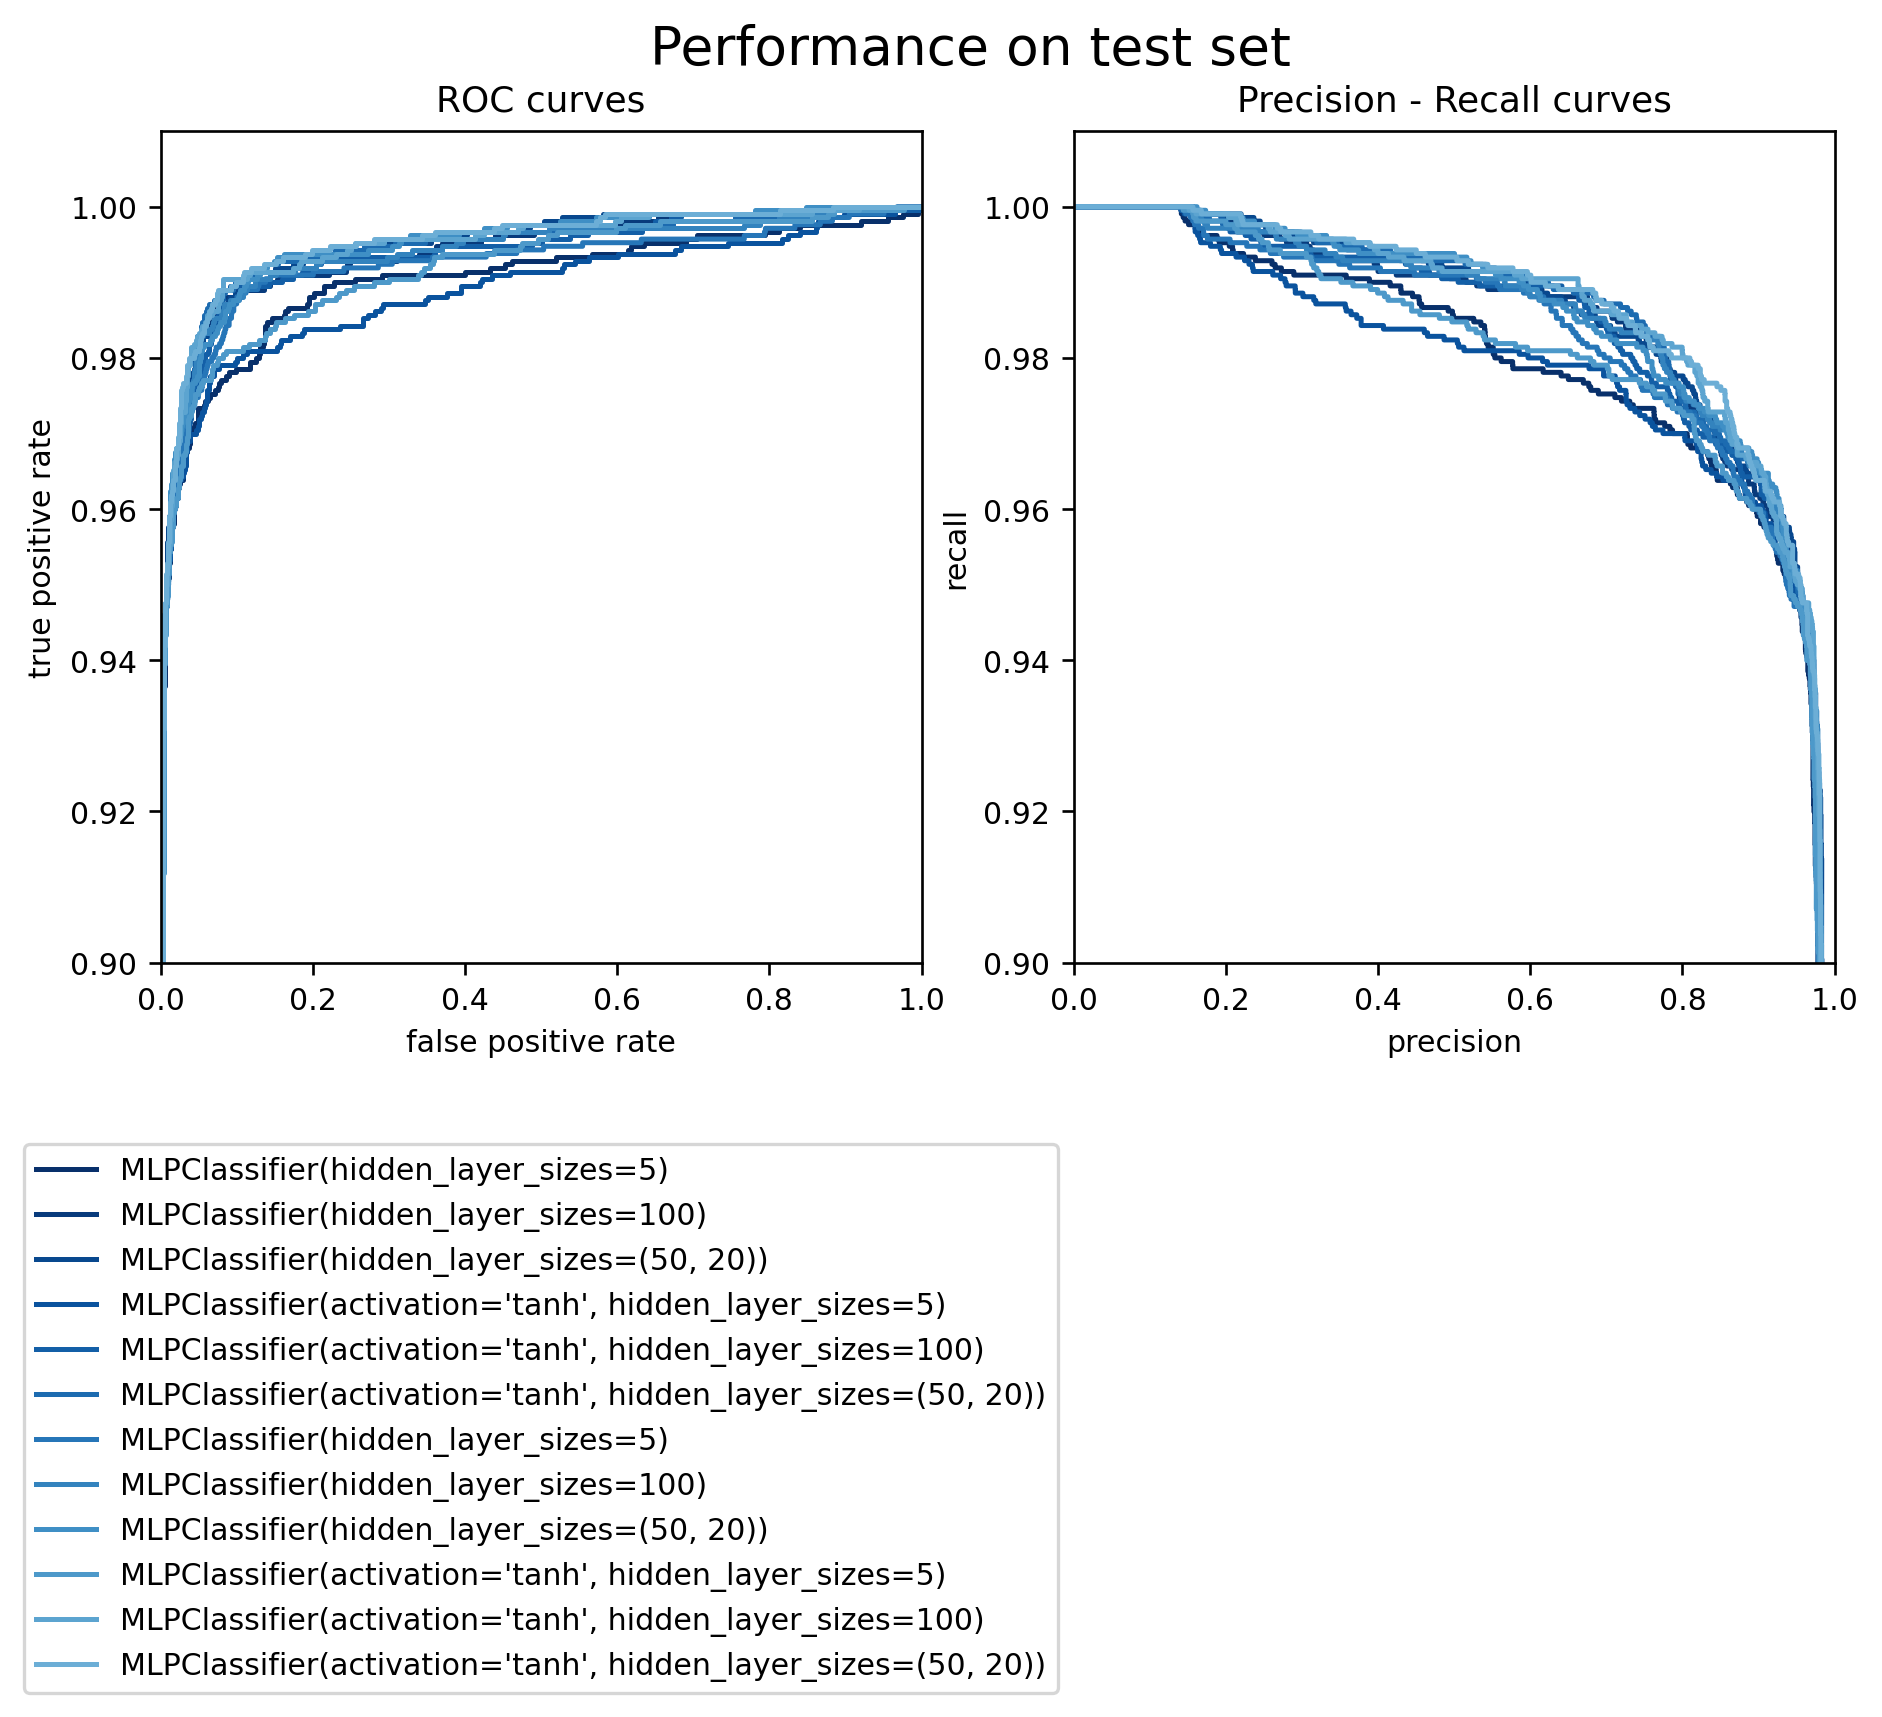

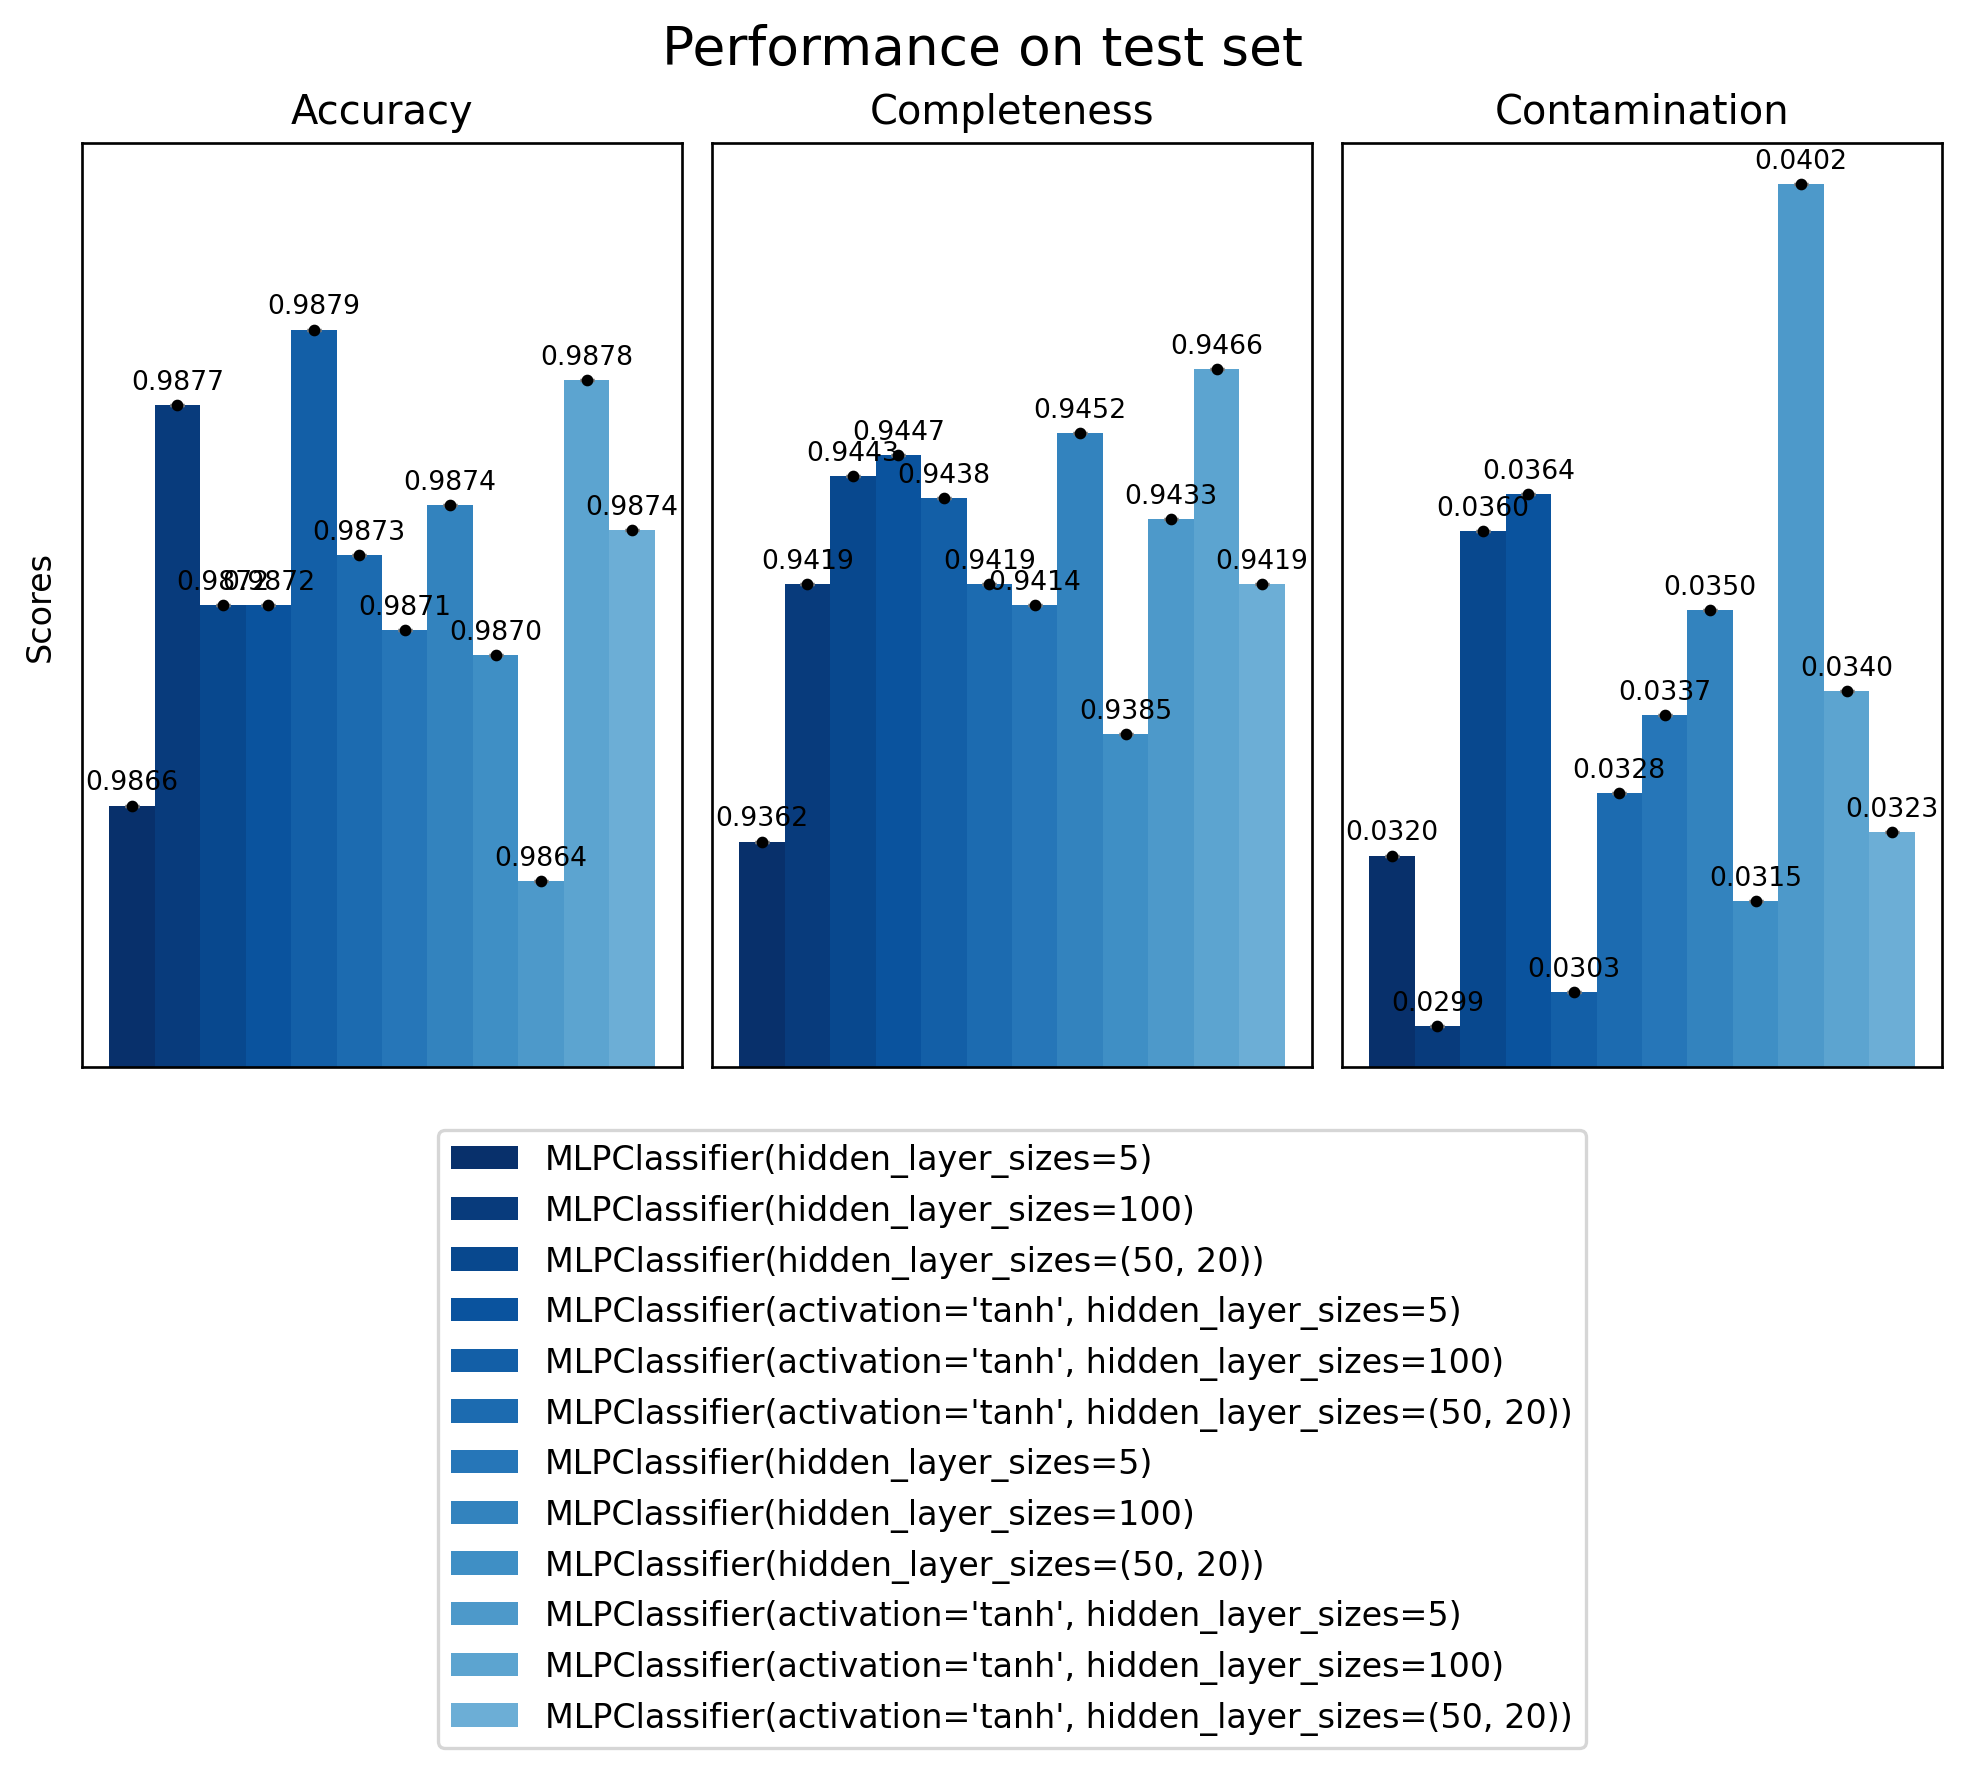

In [258]:
info_list_test = info_list_original_test + info_list_augmented_test

# ---------------Change colormap ----------------------------------------
cmap=plt.cm.Blues_r
c = cycler('color', cmap(np.linspace(0,0.5,len(info_list_tot))) )
plt.rcParams["axes.prop_cycle"] = c

# cmap=plt.cm.tab10
# c = cycler('color', cmap(range(10)))
# plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------
a_test= compare_classifiers(info_list_test, figtitle=f'Performance on test set')

Best performance on test set given by classifier with:
- Architecture (100)
- Activation tanh
- Original dataset

## Dependency on test set choice

In [ ]:
# CV for metrics using base MLP CLassifier
mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

kneighbors = KNeighborsClassifier(9)

mlp_best = MLPClassifier(
                    hidden_layer_sizes=(100),
                    solver='adam', 
                    activation = 'tanh', 
                    learning_rate_init=0.001)

classif_list = [mlp_base, kneighbors, mlp_best]

score_list = ['accuracy', 'recall', 'precision' ]
k=150
splitter = ShuffleSplit(n_splits = k, test_size=0.3)

result_list = []
for classif in classif_list:
    cv_results = cross_validate(classif, X_tot_scaled, y, scoring = score_list, n_jobs=-1, verbose=1, cv=splitter )
    result_list.append(cv_results)
    

In [ ]:
k=300
splitter = ShuffleSplit(n_splits = k, test_size=0.3, random_state=404)

result_list1 = []
for classif in classif_list:
    cv_results = cross_validate(classif, X_tot_scaled, y, scoring = score_list, n_jobs=-1, verbose=1, cv=splitter )
    result_list1.append(cv_results)

In [ ]:
k=300
splitter = ShuffleSplit(n_splits = k, test_size=0.3, random_state=42)

result_list2 = []
for classif in classif_list:
    cv_results = cross_validate(classif, X_tot_scaled, y, scoring = score_list, n_jobs=-1, verbose=1, cv=splitter )
    result_list2.append(cv_results)

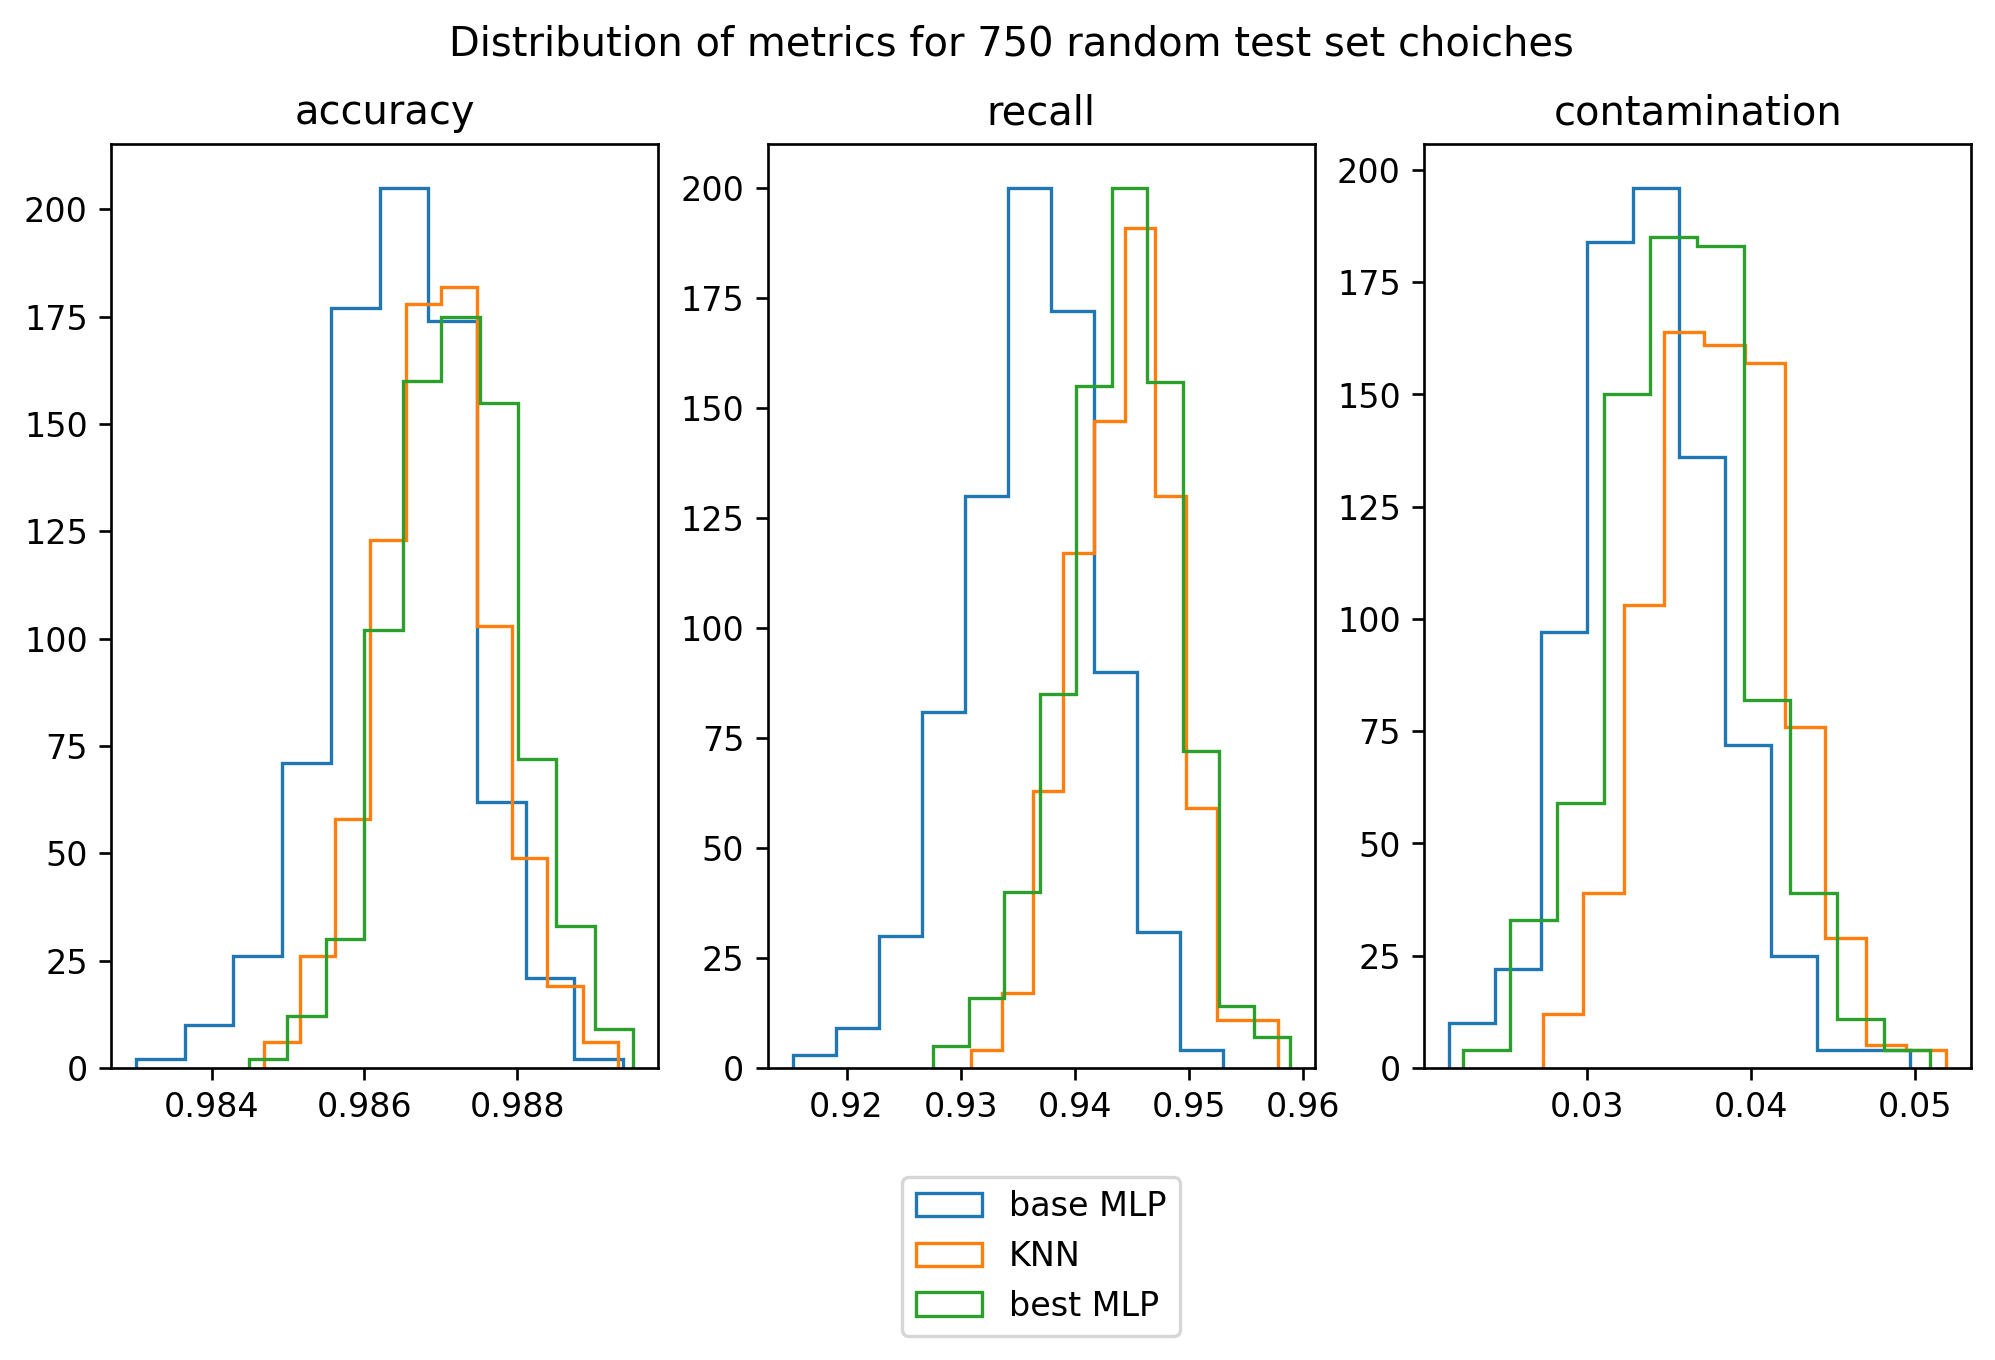

In [308]:
# ---------------Change colormap ----------------------------------------
cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------



acc_list = []
rec_list = []
cont_list = []
                
for list in [result_list, result_list1, result_list2]:
    acc = []
    rec = []
    cont=[]
    
    for res in list:
        acc.append(res['test_accuracy'])
        rec.append(res['test_recall'])
        cont.append(1 - res['test_precision'])

    acc_list.append(np.array(acc))
    rec_list.append(np.array(rec))
    cont_list.append(np.array(cont))

acc_arr = np.concatenate((acc_list[0], acc_list[1], acc_list[2]), axis=1)
rec_arr = np.concatenate((rec_list[0], rec_list[1], rec_list[2]), axis=1)
cont_arr = np.concatenate((cont_list[0], cont_list[1], cont_list[2]), axis=1)


fig, axs = plt.subplots(1,3)
fig.suptitle('Distribution of metrics for 750 random test set choiches')
labels = ['accuracy', 'recall', 'contamination' ]

bins_n = 10

for ax, metric, t in zip(axs, [acc_arr, rec_arr, cont_arr], labels):
    ax.hist(metric[0], histtype='step', label = 'base MLP', bins=bins_n)
    ax.hist(metric[1], histtype='step', label = 'KNN', bins=bins_n)
    ax.hist(metric[2], histtype='step', label = 'best MLP', bins=bins_n)
    ax.set_title(t)
    
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))        


We see that the best MLP classifier has the same performance as a KNN: fine-tuning complex classifiers is not useful with a simple data set like this one.

---